Dataset Paper: https://academic.oup.com/nsr/article/8/3/nwaa180/5896476  
Scanpy: Visualization and data manipulation : https://scanpy.readthedocs.io/en/stable/tutorials.html

You can change the colab runtime to gpu case want to improve pytorch performance


In [1]:
%%capture 
!pip install scanpy
!echo 'yes' | pip install matplotlib==3.1.3 

In [2]:
import pandas as pd
import numpy as np  

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import seaborn as sns 

import torch 
import torch.nn as nn
import torch.nn.functional as F 

import scanpy as sc
import umap
import warnings
warnings.filterwarnings("ignore", category=UserWarning) 

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.21.6 scipy==1.7.3 pandas==1.3.5 scikit-learn==1.0.2 statsmodels==0.12.2 pynndescent==0.5.7


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Downloading the data 

In [ ]:
!wget https://ftp.ncbi.nlm.nih.gov/geo/series/GSE149nnn/GSE149938/suppl/GSE149938_umi_matrix.csv.gz

In [ ]:
!gunzip -d /content/drive/MyDrive/AutoEncoder_HSC/GSE149938_umi_matrix.csv.gz

Matrix is a UMI matrix which counts each gene (from a total of 19813) for each cell (froma total of 7643). 

In [ ]:
matrix = pd.read_csv("/content/drive/MyDrive/AutoEncoder_HSC/GSE149938_umi_matrix.csv")

In [ ]:
# it seems only 0 and 1, but actually there are counts greater than 1
# see below
matrix.head()

OR4F5  FO538757.3  FO538757.2  OR4F29  OR4F16  SAMD11  \
BNK_spBM1_L1_bar25      0           0           0       0       0       0   
BNK_spBM1_L1_bar26      0           0           0       0       0       0   
BNK_spBM1_L1_bar27      0           0           0       0       0       0   
BNK_spBM1_L1_bar28      0           0           0       0       0       0   
BNK_spBM1_L1_bar29      0           0           0       0       0       0   

                    NOC2L  KLHL17  PLEKHN1  PERM1  ...  AC007325.2  \
BNK_spBM1_L1_bar25      0       0        0      0  ...           0   
BNK_spBM1_L1_bar26      0       0        0      0  ...           0   
BNK_spBM1_L1_bar27      0       0        0      0  ...           0   
BNK_spBM1_L1_bar28      0       0        0      0  ...           0   
BNK_spBM1_L1_bar29      0       0        0      0  ...           0   

                    BX072566.1  AL354822.1  AC023491.2  AC004556.1  \
BNK_spBM1_L1_bar25           0           0           0           0   
BNK_spBM1_L1_bar26           0           0           0           1   
BNK_spBM1_L1_bar27           0           0           0           1   
BNK_spBM1_L1_bar28           0           0           0           0   
BNK_spBM1_L1_bar29           0           0           0           0   

                    AC233755.2  AC233755.1  AC240274.1  AC213203.1  FAM231B  
BNK_spBM1_L1_bar25           0           0           0           0        0  
BNK_spBM1_L1_bar26           0           0           0           0        0  
BNK_spBM1_L1_bar27           0           1           0           0        0  
BNK_spBM1_L1_bar28           0           0           0           0        0  
BNK_spBM1_L1_bar29           0           0           0           0        0  

[5 rows x 19813 columns]

# Exploring 

In [ ]:
matrix.shape

(7643, 19813)

In [ ]:
m = matrix.to_numpy()

In [ ]:
m[m > 0].shape

(23599113,)

In [ ]:
m[m > 1].shape

(16422737,)

In [ ]:
m[m > 1]

array([ 2, 19, 13, ..., 16,  7, 24])

There are 32 celltypes as expected 

In [ ]:
index = matrix.index.to_series()
cellnames = index.apply(lambda x: x.split("_")[0])
cellnames

BNK_spBM1_L1_bar25           BNK
BNK_spBM1_L1_bar26           BNK
BNK_spBM1_L1_bar27           BNK
BNK_spBM1_L1_bar28           BNK
BNK_spBM1_L1_bar29           BNK
                           ...  
toxiNK_nkPB2_L12_bar29    toxiNK
toxiNK_nkPB2_L12_bar30    toxiNK
toxiNK_nkPB2_L12_bar31    toxiNK
toxiNK_nkPB2_L12_bar32    toxiNK
toxiNK_nkPB2_L12_bar33    toxiNK
Length: 7643, dtype: object

In [ ]:
len(cellnames.unique())

32

In [ ]:
order = index.apply(lambda x: x.split("_")[0]).value_counts(sort = True, ascending=True)
order

Cell types are unbalanced, as erytrocytes counts are many times greater than other celltypes count ! 

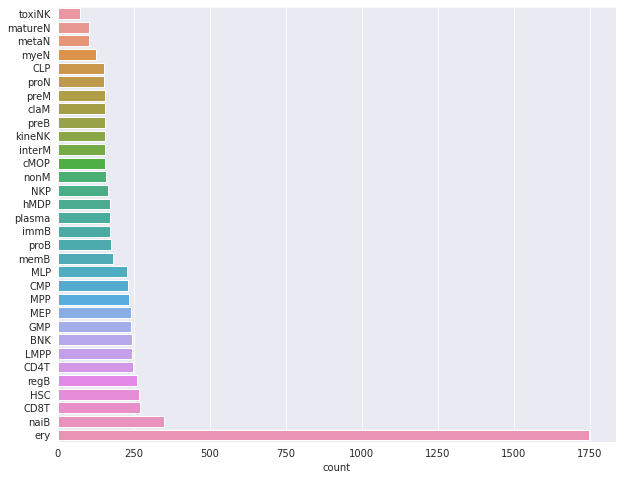

In [ ]:
sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(10, 8))
sns.countplot(y=index.apply(lambda x: x.split("_")[0]), data=index, orient='h', order = order.index)
#plt.setp(ax.get_xticklabels(), rotation=50, horizontalalignment='right')
plt.show()

In [ ]:
matrix.index = cellnames

## PCA  over raw data 

In [ ]:
pca = PCA(n_components=2)
X_2D = pca.fit_transform(matrix.iloc[:,:-2])

In [ ]:
#if 2 Principal Components are used data variance is explained around 80% 
pca.explained_variance_ratio_.sum()

0.8067340319012359

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.scatterplot(x= X_2D[:,0],y = X_2D[:,1],hue=cellnames, hue_order=order.index)
plt.show()

## PCA with 3 components also cannot separate celltypes in clusters! 

In [ ]:
pca = PCA(n_components=3)
X_2D = pca.fit_transform(matrix)

In [ ]:
pca.explained_variance_ratio_.sum()

explained variance improved only 2.7%

In [ ]:
my_color_df =pd.Categorical(matrix.index)
my_color= my_color_df.codes

In [ ]:
my_color.shape

In [ ]:
sns.set_style("white")
fig = plt.figure(1, figsize=(10, 10))
plt.clf()

ax = fig.add_subplot(111, projection="3d", elev=15, azim=45)
ax.set_position([0, 0, 0.95, 1])
ax.scatter(X_2D[:, 0], X_2D[:, 1], X_2D[:, 2],c=my_color, cmap="Set2")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.show()

## Removing ery entries and redoing PCA 

In [ ]:
m_ery = matrix[matrix.index != 'ery']

In [ ]:
pca = PCA(n_components=2)
X_2D = pca.fit_transform(m_ery)

In [ ]:
pca.explained_variance_ratio_.sum()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.scatterplot(x= X_2D[:,0],y = X_2D[:,1],hue=m_ery.index)
plt.show()

Same result ! 

## t-SNE

Clearly the data is not linearly separable, therefore we tried t-SNE to visualize the data in two dimensions 

In [ ]:
pca_50 = PCA(n_components=100)
pca_result_50 = pca_50.fit_transform(matrix)
print('Cumulative explained variation for 50 principal components: {}'.format(np.sum(pca_50.explained_variance_ratio_)))

In [ ]:
tsne = TSNE(n_components=2, verbose=0)
tsne_pca_results = tsne.fit_transform(pca_result_50)


In [ ]:
import colorcet as cc

palette = sns.color_palette(cc.glasbey, n_colors=32)
fig, ax = plt.subplots(figsize=(10, 8))
sns.scatterplot(x= tsne_pca_results[:,0],y = tsne_pca_results[:,1],hue=matrix.index,palette=palette)
plt.legend(bbox_to_anchor=(1.1, 1), loc='upper right', borderaxespad=0)
plt.show()

In [ ]:
with open('/content/drive/MyDrive/AutoEncoder_HSC/GSE149938_series_matrix.txt', 'r') as series:
  print(series.read())

# Filtering data and applying Pearson Residuals 

Before actually ploting PCA, t-SNE and AutoEncoder, it is important to filter cells with low gene counts, remove genes/features with low counts in general (which only augments our feature space) and normalize our counts by cell

In [ ]:
umi = sc.read_csv("/content/drive/MyDrive/AutoEncoder_HSC/GSE149938_umi_matrix.csv")

/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [ ]:
cells_dict = {
    'HSPC':['HSC','MPP', 'CMP', 'MEP', 'LMPP', 'MLP', 'BNK', 'GMP'],  #10% 
    'B':['proB','preB', 'immB','regB','naiB','memB','plasma'], #5%
    'Erythrocyte':['ery'], #2.5%
    'NK':['CLP','NKP','toxiNK','kineNK'],  #5%
    'T':['CD4T','CD8T'],   #2.5%
    'Monocyte':['hMDP','cMOP','preM','nonM','claM','interM'],   #10%
    'Neutrophil':['proN','myeN','matureN','metaN'] #2.5%
              }

" To filter low-quality single cells, **mapping rates** under 10% for HSPCs/monocytes, under 5% for B cells/NK cells/neutrophils/erythrocytes and under 2.5% for T cells were discarded. Simultaneously, we only retained the cells where more than 1000 protein-coding genes/500 lncRNAs were detected, resulting in 7551 cells for protein-coding genes and 7192 cells for lncRNAs "

In [ ]:
umi['proB'].X.shape   # checking, ok 

(176, 19813)

In [ ]:
# not sure if mapping rates are about the reads mapped to genome ratio 
# or genes expressed in each cell 
for kcell in cells_dict:
  for cl in cells_dict[kcell]:

    if kcell == 'HSPC' or kcell == 'Monocyte':
      percent = umi.X.shape[1] * 0.1
      sc.pp.filter_cells(umi, min_genes = percent)

    elif kcell == 'B' or kcell == 'NK':
      percent = umi.X.shape[1] * 0.05
      sc.pp.filter_cells(umi, min_genes = percent)
    
    else:
      percent = umi.X.shape[1] * 0.025
      sc.pp.filter_cells(umi, min_genes = percent)
    


In [ ]:
umi.obs_names_make_unique()
umi.var_names_make_unique()

In [ ]:
sc.pp.filter_cells(umi, min_genes=1000)

In [ ]:
umi.shape

(7643, 19813)

In [ ]:
umi.obs

celltypes  n_genes
BNK_spBM1_L1_bar25           BNK     1869
BNK_spBM1_L1_bar26           BNK     2051
BNK_spBM1_L1_bar27           BNK     3872
BNK_spBM1_L1_bar28           BNK     1475
BNK_spBM1_L1_bar29           BNK     2086
...                          ...      ...
toxiNK_nkPB2_L12_bar29    toxiNK     1839
toxiNK_nkPB2_L12_bar30    toxiNK     1642
toxiNK_nkPB2_L12_bar31    toxiNK     1474
toxiNK_nkPB2_L12_bar32    toxiNK     1691
toxiNK_nkPB2_L12_bar33    toxiNK     1997

[7643 rows x 2 columns]

Actually, there is no cell with number of expressed genes lower than 1000! 

In [ ]:
s = (matrix > 0).sum(axis=1)

In [ ]:
s   # as above, for sanity checking ! 

BNK_spBM1_L1_bar25        1869
BNK_spBM1_L1_bar26        2051
BNK_spBM1_L1_bar27        3872
BNK_spBM1_L1_bar28        1475
BNK_spBM1_L1_bar29        2086
                          ... 
toxiNK_nkPB2_L12_bar29    1839
toxiNK_nkPB2_L12_bar30    1642
toxiNK_nkPB2_L12_bar31    1474
toxiNK_nkPB2_L12_bar32    1691
toxiNK_nkPB2_L12_bar33    1997
Length: 7643, dtype: int64

In [ ]:
s[s < 1000]

Series([], dtype: int64)

In [ ]:
s[s>1500]

BNK_spBM1_L1_bar25        1869
BNK_spBM1_L1_bar26        2051
BNK_spBM1_L1_bar27        3872
BNK_spBM1_L1_bar29        2086
BNK_spBM1_L1_bar30        2038
                          ... 
toxiNK_nkPB2_L12_bar28    1550
toxiNK_nkPB2_L12_bar29    1839
toxiNK_nkPB2_L12_bar30    1642
toxiNK_nkPB2_L12_bar32    1691
toxiNK_nkPB2_L12_bar33    1997
Length: 6384, dtype: int64

In [ ]:
sc.pp.filter_genes(umi, min_cells=3)

filtered out 1314 genes that are detected in less than 3 cells


In [ ]:
umi.shape

(7643, 18499)

In [ ]:
sc.pp.calculate_qc_metrics(
        umi, percent_top=None, log1p=False, inplace=True
    )

In [ ]:
sc.settings.set_figure_params(dpi=80, facecolor="white")

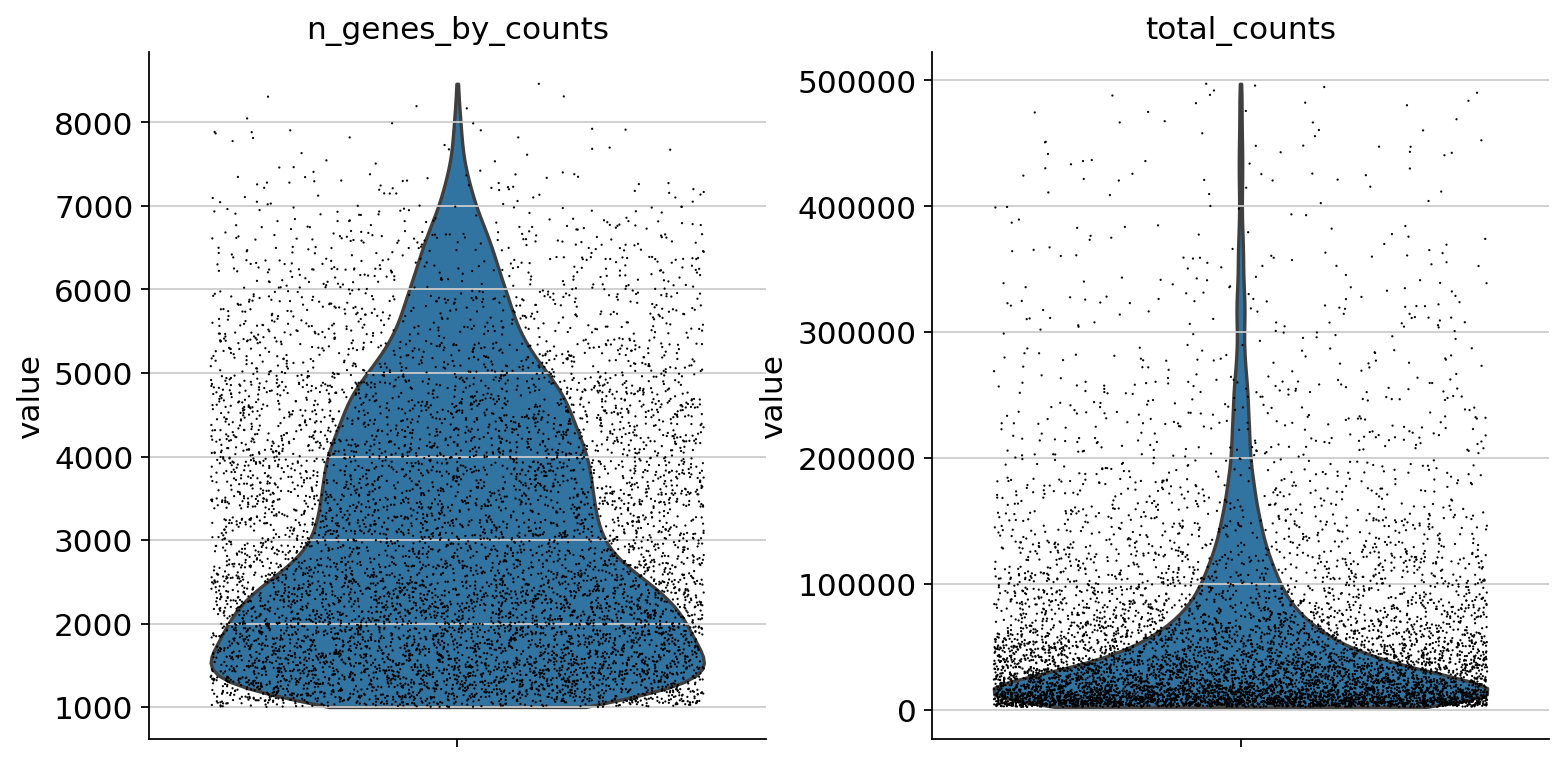

In [ ]:
sc.pl.violin(umi,["n_genes_by_counts", "total_counts"],jitter=0.4,multi_panel=True)


In [ ]:
umi.obs['outlier_ngenes'] = umi.obs.n_genes_by_counts > 7500

In [ ]:
umi = umi[~umi.obs['outlier_ngenes'], :]   #filtering out
sc.pp.filter_genes(umi, min_cells=1)

/usr/local/lib/python3.7/dist-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


In [ ]:
umi.shape

(7614, 18499)

In [ ]:
sc.experimental.pp.highly_variable_genes(umi, flavor="pearson_residuals", n_top_genes=2000)

extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'highly_variable_nbatches', int vector (adata.var)
    'highly_variable_intersection', boolean vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'residual_variances', float vector (adata.var)


Data needs some sort of normalization by counts! There are some outlier genes highly expressed.

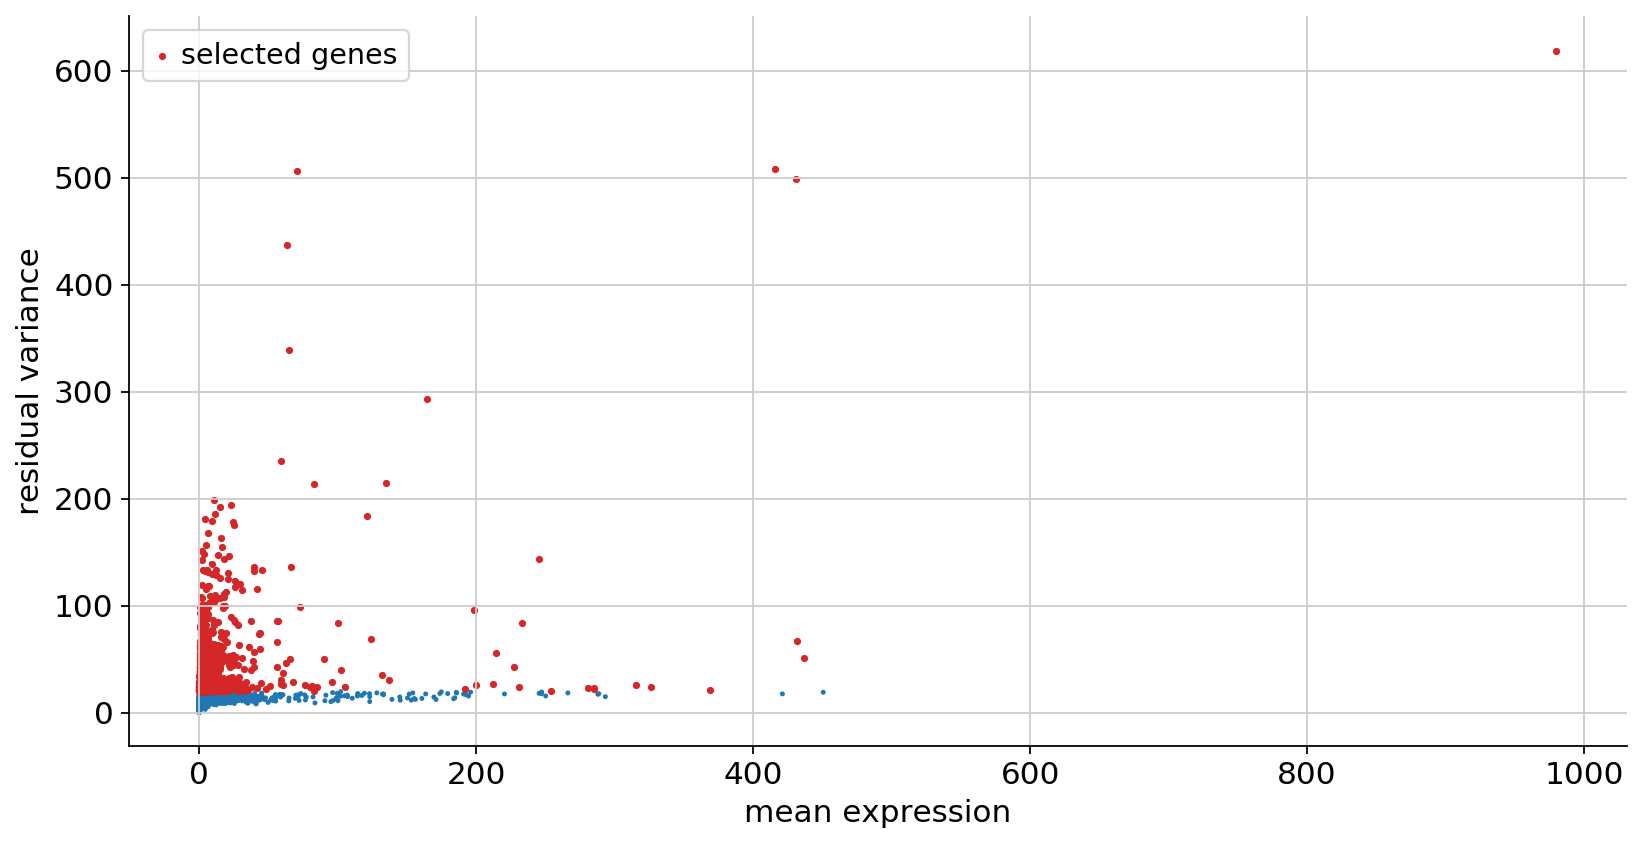

In [ ]:
fig, ax = plt.subplots(1,figsize=(12, 6))
hvgs = umi.var["highly_variable"]

ax.scatter(umi.var["mean_counts"], umi.var["residual_variances"], s=5, edgecolor="none")
ax.scatter(umi.var["mean_counts"][hvgs],umi.var["residual_variances"][hvgs],c="tab:red",
label="selected genes",s=5)

ax.set_xlabel("mean expression")
ax.set_ylabel("residual variance")
#ax.set_title(adata.uns["name"])
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")
#ax.set_xlim([0, 400])
#ax.set_ylim([0, 400])
plt.legend()


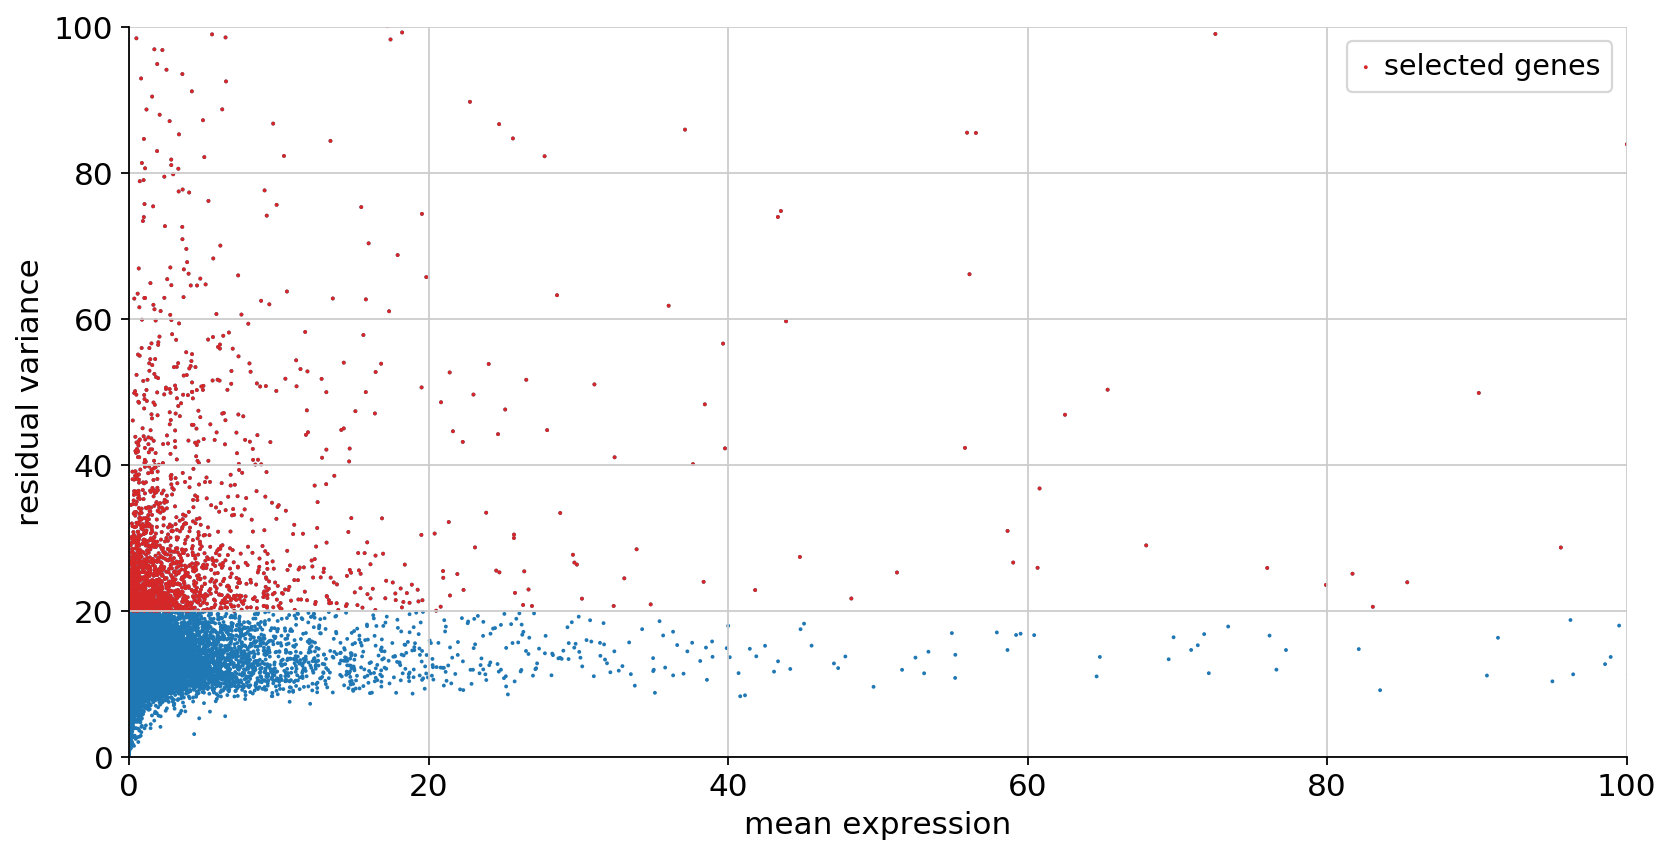

In [ ]:
fig, ax = plt.subplots(1,figsize=(12, 6))
hvgs = umi.var["highly_variable"]

ax.scatter(umi.var["mean_counts"], umi.var["residual_variances"], s=3, edgecolor="none")
ax.scatter(umi.var["mean_counts"][hvgs],umi.var["residual_variances"][hvgs],c="tab:red",
label="selected genes",s=3,edgecolor="none",)

ax.set_xlabel("mean expression")
ax.set_ylabel("residual variance")
#ax.set_title(adata.uns["name"])
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")
ax.set_xlim([0, 100])
ax.set_ylim([0, 100])
plt.legend()

In [ ]:
umi = umi[:, umi.var["highly_variable"]]

In [ ]:
umi.var

n_cells  n_cells_by_counts  mean_counts  pct_dropout_by_counts  \
ISG15        2183               2201     3.168389              71.202407   
TNFRSF18      337                338     0.359021              95.577653   
TNFRSF4       226                230     0.255397              96.990710   
ACAP3        1093               1106     0.936805              85.529242   
MIB2         1167               1183     1.049850              84.521785   
...           ...                ...          ...                    ...   
ADARB1       1066               1082     1.069475              85.843255   
SLC19A1      1173               1185     1.039121              84.495617   
C21orf58     2537               2558     6.090802              66.531467   
DIP2A        3073               3096     4.274761              59.492346   
S100B         196                201     0.203585              97.370143   

          total_counts     means   variances  residual_variances  \
ISG15          24216.0  3.156160  139.886159           26.727892   
TNFRSF18        2744.0  0.355004    9.704903           23.949781   
TNFRSF4         1952.0  0.255450    7.884165           20.380253   
ACAP3           7160.0  0.925401   28.736848           21.815542   
MIB2            8024.0  1.035067   27.771921           20.707354   
...                ...       ...         ...                 ...   
ADARB1          8174.0  1.057657   34.411623           25.282637   
SLC19A1         7942.0  1.023641   25.844443           20.034170   
C21orf58       46552.0  6.041634  460.193853           28.470882   
DIP2A          32672.0  4.190964  154.521258           35.179813   
S100B           1556.0  0.199895    5.965291           27.076889   

          highly_variable_rank  highly_variable  
ISG15                    889.0             True  
TNFRSF18                1208.0             True  
TNFRSF4                 1883.0             True  
ACAP3                   1554.0             True  
MIB2                    1801.0             True  
...                        ...              ...  
ADARB1                  1053.0             True  
SLC19A1                 1978.0             True  
C21orf58                 754.0             True  
DIP2A                    494.0             True  
S100B                    855.0             True  

[2000 rows x 10 columns]

In [ ]:
umi

View of AnnData object with n_obs × n_vars = 7614 × 2000
    obs: 'celltypes', 'n_genes', 'n_genes_by_counts', 'total_counts', 'outlier_ngenes'
    var: 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable'
    uns: 'hvg'

In [ ]:
umi.layers["raw"] = umi.X.copy()
umi.layers["sqrt_norm"] = np.sqrt(
    sc.pp.normalize_total(umi, inplace=False)["X"]
)

normalizing counts per cell
    finished (0:00:00)


In [ ]:
sc.experimental.pp.normalize_pearson_residuals(umi)

computing analytic Pearson residuals on adata.X


/usr/local/lib/python3.7/dist-packages/scanpy/experimental/pp/_normalization.py:45: UserWarning: `normalize_pearson_residuals()` expects raw count data, but non-integers were found.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/scanpy/experimental/pp/_normalization.py:59: RuntimeWarning: invalid value encountered in sqrt
  residuals = diff / np.sqrt(mu + mu**2 / theta)


    finished (0:00:00)


In [ ]:
sc.pp.pca(umi, n_comps=50)
n_cells = len(umi)
sc.tl.tsne(umi, use_rep="X_pca")

In [ ]:
sc.pp.neighbors(umi, n_neighbors=32, n_pcs=50)
#sc.tl.leiden(umi)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)


In [ ]:
umi

AnnData object with n_obs × n_vars = 7614 × 2000
    obs: 'celltypes', 'n_genes', 'n_genes_by_counts', 'total_counts', 'outlier_ngenes'
    var: 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable'
    uns: 'hvg', 'pearson_residuals_normalization', 'pca', 'tsne', 'neighbors', 'celltypes_colors'
    obsm: 'X_pca', 'X_tsne'
    varm: 'PCs'
    layers: 'raw', 'sqrt_norm'
    obsp: 'distances', 'connectivities'

In [ ]:
from matplotlib.pyplot import rc_context

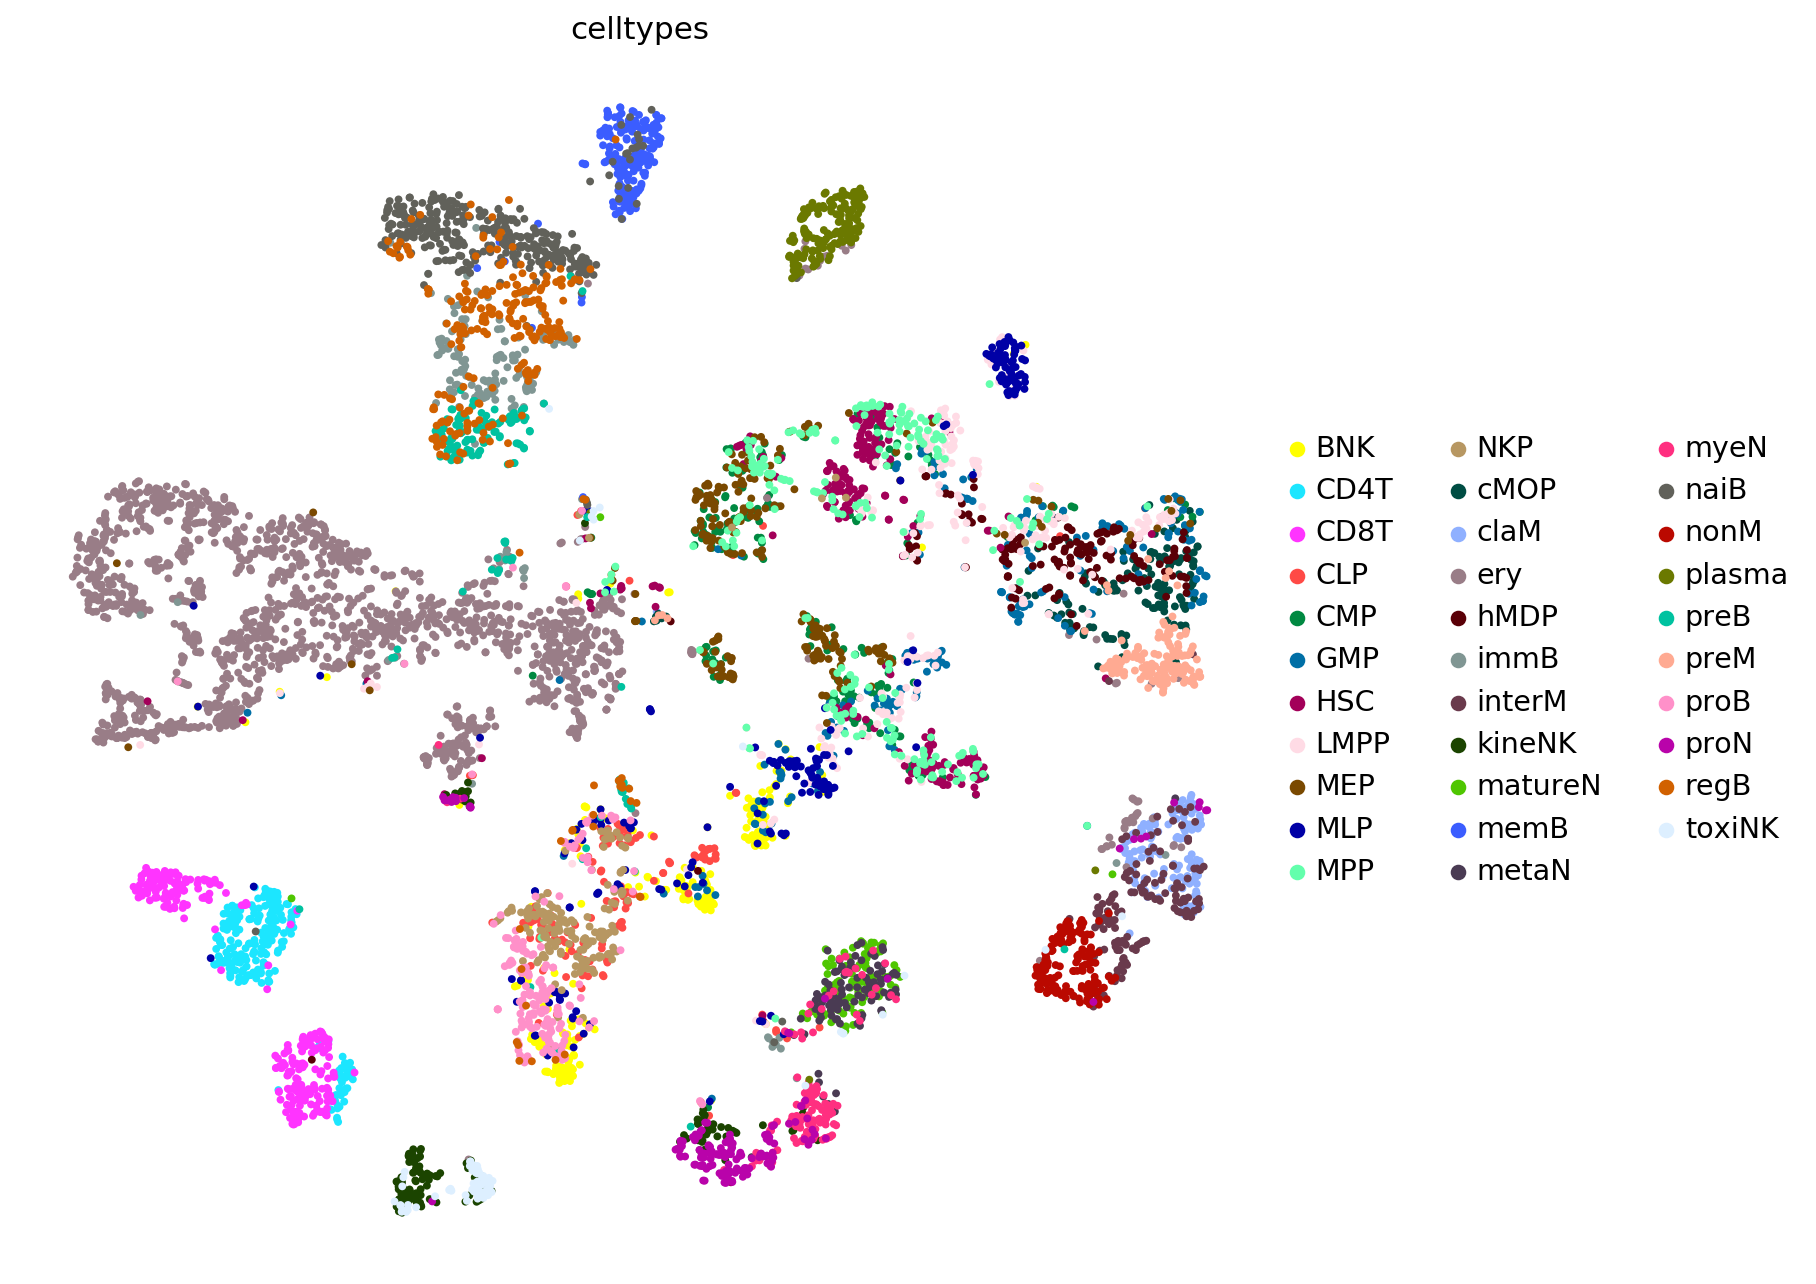

In [ ]:
with rc_context({'figure.figsize': (10, 10)}):
  sc.pl.tsne(umi,color =['celltypes'], cmap="tab20", s=50,  frameon=False)

# Batch Effect: First exploration

Does Lane affects variability of gene expression ? If so, this is not intended, as only biological variability is desired and not technical variability. 

In [ ]:
matrix.head()

OR4F5  FO538757.3  FO538757.2  OR4F29  OR4F16  SAMD11  \
BNK_spBM1_L1_bar25      0           0           0       0       0       0   
BNK_spBM1_L1_bar26      0           0           0       0       0       0   
BNK_spBM1_L1_bar27      0           0           0       0       0       0   
BNK_spBM1_L1_bar28      0           0           0       0       0       0   
BNK_spBM1_L1_bar29      0           0           0       0       0       0   

                    NOC2L  KLHL17  PLEKHN1  PERM1  ...  AC007325.2  \
BNK_spBM1_L1_bar25      0       0        0      0  ...           0   
BNK_spBM1_L1_bar26      0       0        0      0  ...           0   
BNK_spBM1_L1_bar27      0       0        0      0  ...           0   
BNK_spBM1_L1_bar28      0       0        0      0  ...           0   
BNK_spBM1_L1_bar29      0       0        0      0  ...           0   

                    BX072566.1  AL354822.1  AC023491.2  AC004556.1  \
BNK_spBM1_L1_bar25           0           0           0           0   
BNK_spBM1_L1_bar26           0           0           0           1   
BNK_spBM1_L1_bar27           0           0           0           1   
BNK_spBM1_L1_bar28           0           0           0           0   
BNK_spBM1_L1_bar29           0           0           0           0   

                    AC233755.2  AC233755.1  AC240274.1  AC213203.1  FAM231B  
BNK_spBM1_L1_bar25           0           0           0           0        0  
BNK_spBM1_L1_bar26           0           0           0           0        0  
BNK_spBM1_L1_bar27           0           1           0           0        0  
BNK_spBM1_L1_bar28           0           0           0           0        0  
BNK_spBM1_L1_bar29           0           0           0           0        0  

[5 rows x 19813 columns]

In [ ]:
mean_by_cell = matrix.iloc[:,:-3].mean(axis=1)
mean_by_cell

BNK_spBM1_L1_bar25        1.236446
BNK_spBM1_L1_bar26        3.128723
BNK_spBM1_L1_bar27        6.278748
BNK_spBM1_L1_bar28        0.411106
BNK_spBM1_L1_bar29        2.706310
                            ...   
toxiNK_nkPB2_L12_bar29    2.218274
toxiNK_nkPB2_L12_bar30    2.283190
toxiNK_nkPB2_L12_bar31    0.386118
toxiNK_nkPB2_L12_bar32    1.629076
toxiNK_nkPB2_L12_bar33    2.219889
Length: 7643, dtype: float64

In [ ]:
lanes = matrix.index.to_series().apply(lambda x: x.split("_")[2])
lanes

BNK_spBM1_L1_bar25         L1
BNK_spBM1_L1_bar26         L1
BNK_spBM1_L1_bar27         L1
BNK_spBM1_L1_bar28         L1
BNK_spBM1_L1_bar29         L1
                         ... 
toxiNK_nkPB2_L12_bar29    L12
toxiNK_nkPB2_L12_bar30    L12
toxiNK_nkPB2_L12_bar31    L12
toxiNK_nkPB2_L12_bar32    L12
toxiNK_nkPB2_L12_bar33    L12
Length: 7643, dtype: object

In [ ]:
celltypes = matrix.index.to_series().apply(lambda x: x.split("_")[0])
sample = matrix.index.to_series().apply(lambda x: x.split("_")[1])

In [ ]:
df = pd.DataFrame({'lanes':lanes, 'mean_cell_count':mean_by_cell})
df

lanes  mean_cell_count
BNK_spBM1_L1_bar25        L1         1.236446
BNK_spBM1_L1_bar26        L1         3.128723
BNK_spBM1_L1_bar27        L1         6.278748
BNK_spBM1_L1_bar28        L1         0.411106
BNK_spBM1_L1_bar29        L1         2.706310
...                      ...              ...
toxiNK_nkPB2_L12_bar29   L12         2.218274
toxiNK_nkPB2_L12_bar30   L12         2.283190
toxiNK_nkPB2_L12_bar31   L12         0.386118
toxiNK_nkPB2_L12_bar32   L12         1.629076
toxiNK_nkPB2_L12_bar33   L12         2.219889

[7643 rows x 2 columns]

In [ ]:
df.groupby('lanes').mean().T

lanes                 L1       L10       L11       L12       L13      L14  \
mean_cell_count  3.13897  1.541873  1.499228  2.165287  1.592598  1.75684   

lanes                 L15      L16       L17       L18  ...       L29  \
mean_cell_count  2.400248  1.73403  2.228664  2.180502  ...  3.084561   

lanes                  L3       L30       L31        L4        L5        L6  \
mean_cell_count  3.259757  1.684663  1.500434  3.326406  3.036074  2.802922   

lanes                  L7        L8        L9  
mean_cell_count  3.973408  4.199721  3.877265  

[1 rows x 31 columns]

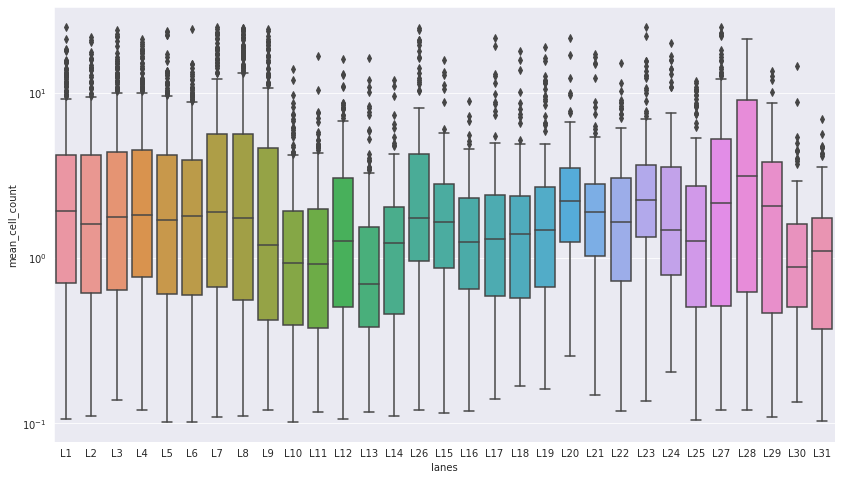

In [ ]:
sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(14, 8))
sns.boxplot(data=df,y='mean_cell_count',x='lanes', orient='v')
ax.set_yscale('log')
plt.show()

In [ ]:
df.groupby('lanes').sample(20)

lanes  mean_cell_count
myeN_nBM1_L1_bar22       L1         0.649773
CD8T_tPB_L1_bar62        L1         0.434326
nonM_moBM1_L1_bar86      L1         5.287128
interM_moBM2_L1_bar61    L1         4.969864
MPP_spBM1_L1_bar83       L1         3.239324
...                     ...              ...
GMP_spBM1_L9_bar50       L9        19.426754
kineNK_nkPB1_L9_bar24    L9         0.338415
MEP_spBM1_L9_bar6        L9         0.398233
interM_moBM2_L9_bar28    L9         0.389601
interM_moBM1_L9_bar66    L9         2.787885

[620 rows x 2 columns]

In [ ]:
df[df['lanes'] == f'L31'].index.to_series().apply(lambda x:x.split("_")[0]).unique()

array(['ery'], dtype=object)

In [ ]:
lane_dict = {}
for i in range(1,32):
  l = f'L{i}'
  lane_dict[l] = len(df[df['lanes'] == f'L{i}'].index.to_series().apply(lambda x:x.split("_")[0]).unique())


Text(0, 0.5, 'Unique cell types')

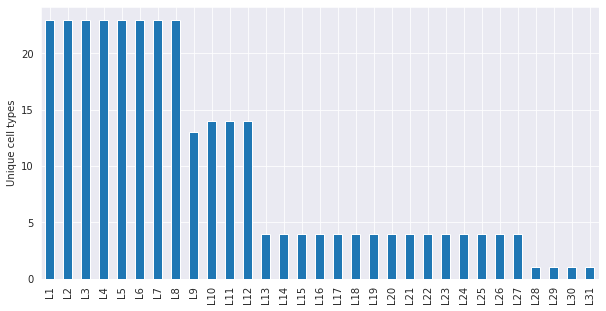

In [ ]:
fig,ax = plt.subplots(figsize=(10,5))
pd.Series(lane_dict).plot(kind='bar')
ax.set_ylabel('Unique cell types')

In [ ]:
df[df['lanes'] == f'L1'].index.to_series().apply(lambda x:x.split("_")[0]).unique()

array(['BNK', 'CD4T', 'CD8T', 'claM', 'CLP', 'cMOP', 'CMP', 'ery', 'GMP',
       'hMDP', 'HSC', 'interM', 'LMPP', 'matureN', 'MEP', 'metaN', 'MLP',
       'MPP', 'myeN', 'NKP', 'nonM', 'preM', 'proN'], dtype=object)

Lanes have different distributions of cell types and it seems that the cell types were randomly distributed between Lanes, as L1 has 23 cell types with distinct origins, such as Ery and NK

## Verifying if randomly samples from each lane are correlated 

In [ ]:
matrix.head()

OR4F5  FO538757.3  FO538757.2  OR4F29  OR4F16  SAMD11  \
BNK_spBM1_L1_bar25      0           0           0       0       0       0   
BNK_spBM1_L1_bar26      0           0           0       0       0       0   
BNK_spBM1_L1_bar27      0           0           0       0       0       0   
BNK_spBM1_L1_bar28      0           0           0       0       0       0   
BNK_spBM1_L1_bar29      0           0           0       0       0       0   

                    NOC2L  KLHL17  PLEKHN1  PERM1  ...  AC007325.2  \
BNK_spBM1_L1_bar25      0       0        0      0  ...           0   
BNK_spBM1_L1_bar26      0       0        0      0  ...           0   
BNK_spBM1_L1_bar27      0       0        0      0  ...           0   
BNK_spBM1_L1_bar28      0       0        0      0  ...           0   
BNK_spBM1_L1_bar29      0       0        0      0  ...           0   

                    BX072566.1  AL354822.1  AC023491.2  AC004556.1  \
BNK_spBM1_L1_bar25           0           0           0           0   
BNK_spBM1_L1_bar26           0           0           0           1   
BNK_spBM1_L1_bar27           0           0           0           1   
BNK_spBM1_L1_bar28           0           0           0           0   
BNK_spBM1_L1_bar29           0           0           0           0   

                    AC233755.2  AC233755.1  AC240274.1  AC213203.1  FAM231B  
BNK_spBM1_L1_bar25           0           0           0           0        0  
BNK_spBM1_L1_bar26           0           0           0           0        0  
BNK_spBM1_L1_bar27           0           1           0           0        0  
BNK_spBM1_L1_bar28           0           0           0           0        0  
BNK_spBM1_L1_bar29           0           0           0           0        0  

[5 rows x 19813 columns]

In [ ]:
matrix['lanes'] = matrix.index.to_series().apply(lambda x: x.split("_")[2])
matrix['celltype'] = matrix.index.to_series().apply(lambda x: x.split("_")[0])

In [ ]:
sample = matrix.groupby('lanes').sample(8)
sample

OR4F5  FO538757.3  FO538757.2  OR4F29  OR4F16  SAMD11  \
MPP_spBM2_L1_bar85       0           0           0       0       0       0   
CLP_nkBM2_L1_bar32       0           0           0       0       0       0   
NKP_nkBM2_L1_bar85       0           0           0       0       0       0   
CLP_nkBM2_L1_bar28       0           0           0       0       0       0   
nonM_moBM1_L1_bar83      0           0           0       0       0       0   
...                    ...         ...         ...     ...     ...     ...   
GMP_spBM1_L9_bar40       0           0           0       0       0       0   
ery_eBM1_L9_bar29        0           0           0       0       0       0   
ery_eBM1_L9_bar30        0           0           0       0       0       0   
CMP_spBM1_L9_bar70       0           0           0       0       0       0   
ery_eBM3_L9_bar66        0           0           0       0       0       0   

                     NOC2L  KLHL17  PLEKHN1  PERM1  ...  AL354822.1  \
MPP_spBM2_L1_bar85       0       0        0      0  ...           0   
CLP_nkBM2_L1_bar32       0       0        0      0  ...           0   
NKP_nkBM2_L1_bar85       0       0        0      0  ...           0   
CLP_nkBM2_L1_bar28       0       0        0      0  ...           0   
nonM_moBM1_L1_bar83      0       0        0      0  ...           0   
...                    ...     ...      ...    ...  ...         ...   
GMP_spBM1_L9_bar40       0       0        0      0  ...           0   
ery_eBM1_L9_bar29        0       0        0      0  ...           0   
ery_eBM1_L9_bar30        0       0        0      0  ...           0   
CMP_spBM1_L9_bar70       2       0        0      0  ...           0   
ery_eBM3_L9_bar66        0       0        0      0  ...           0   

                     AC023491.2  AC004556.1  AC233755.2  AC233755.1  \
MPP_spBM2_L1_bar85            0           0           0           0   
CLP_nkBM2_L1_bar32            0           0           0           0   
NKP_nkBM2_L1_bar85            0           0           0           0   
CLP_nkBM2_L1_bar28            0           0           0           0   
nonM_moBM1_L1_bar83           0           0           0           0   
...                         ...         ...         ...         ...   
GMP_spBM1_L9_bar40            0           0           0           0   
ery_eBM1_L9_bar29             0           0           0           0   
ery_eBM1_L9_bar30             0           0           0           0   
CMP_spBM1_L9_bar70            0           0           0           0   
ery_eBM3_L9_bar66             0           0           0           0   

                     AC240274.1  AC213203.1  FAM231B  lanes  celltype  
MPP_spBM2_L1_bar85            0           0        0     L1       MPP  
CLP_nkBM2_L1_bar32            0           0        0     L1       CLP  
NKP_nkBM2_L1_bar85            0           0        0     L1       NKP  
CLP_nkBM2_L1_bar28            0           0        0     L1       CLP  
nonM_moBM1_L1_bar83           0           0        0     L1      nonM  
...                         ...         ...      ...    ...       ...  
GMP_spBM1_L9_bar40            0           0        0     L9       GMP  
ery_eBM1_L9_bar29             0           0        0     L9       ery  
ery_eBM1_L9_bar30             0           0        0     L9       ery  
CMP_spBM1_L9_bar70            0           0        0     L9       CMP  
ery_eBM3_L9_bar66             0           0        0     L9       ery  

[248 rows x 19815 columns]

In [ ]:
pca_50 = PCA(n_components=100)
pca_result_50 = pca_50.fit_transform(matrix.iloc[:,:-2])
print('Cumulative explained variation for 50 principal components: {}'.format(np.sum(pca_50.explained_variance_ratio_)))

Cumulative explained variation for 50 principal components: 0.9539098308373841


In [ ]:
tsne = TSNE(n_components=2, verbose=0)
tsne_pca_results = tsne.fit_transform(pca_result_50)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


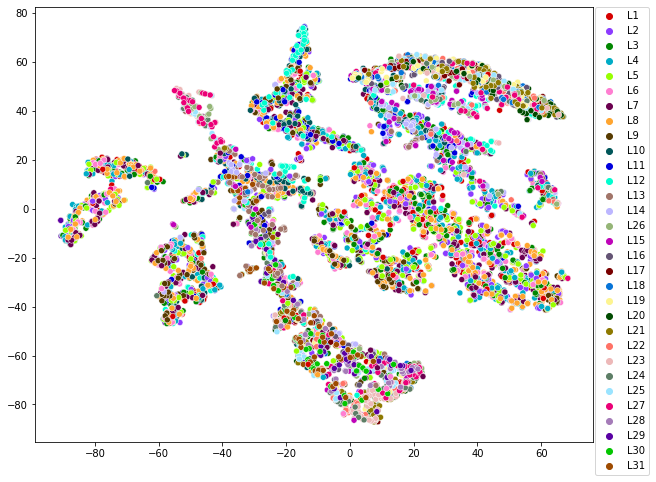

In [ ]:
import colorcet as cc

palette = sns.color_palette(cc.glasbey, n_colors=31)
fig, ax = plt.subplots(figsize=(10, 8))
sns.scatterplot(x= tsne_pca_results[:,0],y = tsne_pca_results[:,1],hue=matrix['lanes'],palette=palette)
plt.legend(bbox_to_anchor=(1.1, 1), loc='upper right', borderaxespad=0)
plt.show()

Batch effect does not seems predominant in a t-SNE applied on a raw UMI count, coloured by lane. That is because points representing cells of each lane are dispersed among different clusters, in general. Nevertheless, L27 and L12 share datapoints clustered together... 

In [ ]:
matrix.groupby(['lanes', 'celltype']).mean()

OR4F5  FO538757.3  FO538757.2  OR4F29    OR4F16    SAMD11  \
lanes celltype                                                              
L1    BNK         0.0         0.0    0.122449     0.0  0.000000  0.285714   
      CD4T        0.0         0.0    0.000000     0.0  0.000000  0.000000   
      CD8T        0.0         0.0    0.000000     0.0  0.000000  0.000000   
      CLP         0.0         0.0    0.195122     0.0  0.000000  0.000000   
      CMP         0.0         0.0    0.307692     0.0  0.000000  1.769231   
...               ...         ...         ...     ...       ...       ...   
L9    hMDP        0.0         0.0    0.000000     0.0  0.000000  0.000000   
      interM      0.0         0.0    0.461538     0.0  0.000000  1.384615   
      kineNK      0.0         0.0    0.235294     0.0  0.000000  0.000000   
      nonM        0.0         0.0    0.071429     0.0  0.071429  0.000000   
      preM        0.0         0.0    0.100000     0.0  0.000000  0.000000   

                   NOC2L    KLHL17   PLEKHN1  PERM1  ...  AC007325.2  \
lanes celltype                                       ...               
L1    BNK       1.367347  0.000000  0.020408    0.0  ...    0.000000   
      CD4T      0.000000  0.000000  0.000000    0.0  ...    0.000000   
      CD8T      0.000000  0.131579  0.000000    0.0  ...    0.000000   
      CLP       0.560976  0.121951  0.000000    0.0  ...    0.000000   
      CMP       3.307692  0.000000  0.000000    0.0  ...    0.000000   
...                  ...       ...       ...    ...  ...         ...   
L9    hMDP      2.642857  0.000000  0.000000    0.0  ...    0.214286   
      interM    1.000000  0.846154  0.000000    0.0  ...    0.000000   
      kineNK    0.000000  0.529412  0.000000    0.0  ...    0.000000   
      nonM      2.785714  0.071429  0.000000    0.0  ...    0.000000   
      preM      0.500000  1.600000  0.000000    0.0  ...    0.000000   

                BX072566.1  AL354822.1  AC023491.2  AC004556.1  AC233755.2  \
lanes celltype                                                               
L1    BNK              0.0         0.0         0.0    0.693878         0.0   
      CD4T             0.0         0.0         0.0    0.000000         0.0   
      CD8T             0.0         0.0         0.0    0.052632         0.0   
      CLP              0.0         0.0         0.0    0.243902         0.0   
      CMP              0.0         0.0         0.0    0.384615         0.0   
...                    ...         ...         ...         ...         ...   
L9    hMDP             0.0         0.0         0.0    2.071429         0.0   
      interM           0.0         0.0         0.0    0.000000         0.0   
      kineNK           0.0         0.0         0.0    0.000000         0.0   
      nonM             0.0         0.0         0.0    0.571429         0.0   
      preM             0.0         0.0         0.0    0.000000         0.0   

                AC233755.1  AC240274.1  AC213203.1  FAM231B  
lanes celltype                                               
L1    BNK         0.183673    0.040816         0.0      0.0  
      CD4T        0.000000    0.000000         0.0      0.0  
      CD8T        0.000000    0.000000         0.0      0.0  
      CLP         0.000000    0.000000         0.0      0.0  
      CMP         0.000000    0.076923         0.0      0.0  
...                    ...         ...         ...      ...  
L9    hMDP        0.000000    0.071429         0.0      0.0  
      interM      0.000000    0.153846         0.0      0.0  
      kineNK      0.000000    0.058824         0.0      0.0  
      nonM        0.000000    0.000000         0.0      0.0  
      preM        0.000000    0.100000         0.0      0.0  

[303 rows x 19813 columns]

In [ ]:
mean_counts = matrix.iloc[:,:-2].mean(axis=1)
celltypes = matrix.index.to_series().apply(lambda x: x.split("_")[0])
lanes = matrix.index.to_series().apply(lambda x: x.split("_")[2])
batch_df = pd.concat([mean_counts,celltypes,lanes], axis=1)
batch_df.columns = ['mean_count','celltype','lane']
batch_df

mean_count celltype lane
BNK_spBM1_L1_bar25        1.236259      BNK   L1
BNK_spBM1_L1_bar26        3.128249      BNK   L1
BNK_spBM1_L1_bar27        6.277797      BNK   L1
BNK_spBM1_L1_bar28        0.411043      BNK   L1
BNK_spBM1_L1_bar29        2.705900      BNK   L1
...                            ...      ...  ...
toxiNK_nkPB2_L12_bar29    2.217938   toxiNK  L12
toxiNK_nkPB2_L12_bar30    2.282845   toxiNK  L12
toxiNK_nkPB2_L12_bar31    0.386060   toxiNK  L12
toxiNK_nkPB2_L12_bar32    1.628830   toxiNK  L12
toxiNK_nkPB2_L12_bar33    2.219553   toxiNK  L12

[7643 rows x 3 columns]

In [ ]:
batch_df.groupby(['lane','celltype']).mean()

mean_count
lane celltype            
L1   BNK         3.638487
     CD4T        0.318940
     CD8T        0.491551
     CLP         2.981106
     CMP         6.911030
...                   ...
L9   hMDP        3.016886
     interM      1.729160
     kineNK      0.793635
     nonM        1.652775
     preM        1.820365

[303 rows x 1 columns]

In [ ]:
df = matrix.groupby(['lanes','celltype']).mean()
df

OR4F5  FO538757.3  FO538757.2  OR4F29    OR4F16    SAMD11  \
lanes celltype                                                              
L1    BNK         0.0         0.0    0.122449     0.0  0.000000  0.285714   
      CD4T        0.0         0.0    0.000000     0.0  0.000000  0.000000   
      CD8T        0.0         0.0    0.000000     0.0  0.000000  0.000000   
      CLP         0.0         0.0    0.195122     0.0  0.000000  0.000000   
      CMP         0.0         0.0    0.307692     0.0  0.000000  1.769231   
...               ...         ...         ...     ...       ...       ...   
L9    hMDP        0.0         0.0    0.000000     0.0  0.000000  0.000000   
      interM      0.0         0.0    0.461538     0.0  0.000000  1.384615   
      kineNK      0.0         0.0    0.235294     0.0  0.000000  0.000000   
      nonM        0.0         0.0    0.071429     0.0  0.071429  0.000000   
      preM        0.0         0.0    0.100000     0.0  0.000000  0.000000   

                   NOC2L    KLHL17   PLEKHN1  PERM1  ...  AC007325.2  \
lanes celltype                                       ...               
L1    BNK       1.367347  0.000000  0.020408    0.0  ...    0.000000   
      CD4T      0.000000  0.000000  0.000000    0.0  ...    0.000000   
      CD8T      0.000000  0.131579  0.000000    0.0  ...    0.000000   
      CLP       0.560976  0.121951  0.000000    0.0  ...    0.000000   
      CMP       3.307692  0.000000  0.000000    0.0  ...    0.000000   
...                  ...       ...       ...    ...  ...         ...   
L9    hMDP      2.642857  0.000000  0.000000    0.0  ...    0.214286   
      interM    1.000000  0.846154  0.000000    0.0  ...    0.000000   
      kineNK    0.000000  0.529412  0.000000    0.0  ...    0.000000   
      nonM      2.785714  0.071429  0.000000    0.0  ...    0.000000   
      preM      0.500000  1.600000  0.000000    0.0  ...    0.000000   

                BX072566.1  AL354822.1  AC023491.2  AC004556.1  AC233755.2  \
lanes celltype                                                               
L1    BNK              0.0         0.0         0.0    0.693878         0.0   
      CD4T             0.0         0.0         0.0    0.000000         0.0   
      CD8T             0.0         0.0         0.0    0.052632         0.0   
      CLP              0.0         0.0         0.0    0.243902         0.0   
      CMP              0.0         0.0         0.0    0.384615         0.0   
...                    ...         ...         ...         ...         ...   
L9    hMDP             0.0         0.0         0.0    2.071429         0.0   
      interM           0.0         0.0         0.0    0.000000         0.0   
      kineNK           0.0         0.0         0.0    0.000000         0.0   
      nonM             0.0         0.0         0.0    0.571429         0.0   
      preM             0.0         0.0         0.0    0.000000         0.0   

                AC233755.1  AC240274.1  AC213203.1  FAM231B  
lanes celltype                                               
L1    BNK         0.183673    0.040816         0.0      0.0  
      CD4T        0.000000    0.000000         0.0      0.0  
      CD8T        0.000000    0.000000         0.0      0.0  
      CLP         0.000000    0.000000         0.0      0.0  
      CMP         0.000000    0.076923         0.0      0.0  
...                    ...         ...         ...      ...  
L9    hMDP        0.000000    0.071429         0.0      0.0  
      interM      0.000000    0.153846         0.0      0.0  
      kineNK      0.000000    0.058824         0.0      0.0  
      nonM        0.000000    0.000000         0.0      0.0  
      preM        0.000000    0.100000         0.0      0.0  

[303 rows x 19813 columns]

Let's check which cell types are present in all lanes and then try to use those celltypes to check for batch effect more precisely.

In [ ]:
lane_dict = {}
for i in range(1,32):
  l = f'L{i}'
  lane_dict[l] = matrix[matrix['lanes'] == f'L{i}'].index.to_series().apply(lambda x:x.split("_")[0]).unique()

In [ ]:
matrix['celltype'].unique()

array(['BNK', 'CD4T', 'CD8T', 'claM', 'CLP', 'cMOP', 'CMP', 'ery', 'GMP',
       'hMDP', 'HSC', 'immB', 'interM', 'kineNK', 'LMPP', 'matureN',
       'memB', 'MEP', 'metaN', 'MLP', 'MPP', 'myeN', 'naiB', 'NKP',
       'nonM', 'plasma', 'preB', 'preM', 'proB', 'proN', 'regB', 'toxiNK'],
      dtype=object)

In [ ]:
ct_ovl = set(cl for cl in matrix['celltype'].unique())
for l in lane_dict:
  lane_cells = lane_dict[l].tolist()
  ct_ovl = ct_ovl.intersection(set(lane_cells))

ct_ovl

{'ery'}

Only 'ery' cells are present in all lanes.

In [ ]:
ery = df.xs('ery', level='celltype')

In [ ]:
ery

OR4F5  FO538757.3  FO538757.2  OR4F29    OR4F16    SAMD11     NOC2L  \
lanes                                                                        
L1       0.0         0.0    0.123288     0.0  0.000000  0.013699  0.561644   
L10      0.0         0.0    0.000000     0.0  0.032787  0.032787  0.377049   
L11      0.0         0.0    0.021277     0.0  0.000000  0.000000  0.510638   
L12      0.0         0.0    0.000000     0.0  0.000000  0.016667  0.150000   
L13      0.0         0.0    0.017241     0.0  0.000000  0.000000  0.086207   
L14      0.0         0.0    0.031250     0.0  0.000000  0.000000  0.281250   
L15      0.0         0.0    0.147059     0.0  0.000000  0.000000  0.970588   
L16      0.0         0.0    0.057143     0.0  0.000000  0.000000  0.371429   
L17      0.0         0.0    0.025641     0.0  0.025641  0.025641  0.102564   
L18      0.0         0.0    0.085714     0.0  0.000000  0.000000  0.114286   
L19      0.0         0.0    0.489796     0.0  0.020408  0.000000  0.163265   
L2       0.0         0.0    0.000000     0.0  0.029851  0.000000  0.179104   
L20      0.0         0.0    0.021739     0.0  0.000000  0.000000  0.195652   
L21      0.0         0.0    0.111111     0.0  0.000000  0.022222  0.977778   
L22      0.0         0.0    0.000000     0.0  0.000000  0.000000  0.020408   
L23      0.0         0.0    0.210526     0.0  0.013158  0.000000  0.078947   
L24      0.0         0.0    0.255814     0.0  0.000000  0.000000  0.697674   
L25      0.0         0.0    0.259259     0.0  0.000000  0.000000  0.185185   
L26      0.0         0.0    0.187500     0.0  0.000000  0.031250  1.562500   
L27      0.0         0.0    0.149254     0.0  0.029851  0.029851  2.731343   
L28      0.0         0.0    0.135593     0.0  0.000000  0.000000  0.745763   
L29      0.0         0.0    0.000000     0.0  0.019231  0.000000  0.000000   
L3       0.0         0.0    0.012821     0.0  0.000000  0.012821  0.358974   
L30      0.0         0.0    0.029851     0.0  0.014925  0.000000  0.537313   
L31      0.0         0.0    0.038462     0.0  0.012821  0.012821  0.282051   
L4       0.0         0.0    0.000000     0.0  0.023256  0.000000  0.093023   
L5       0.0         0.0    0.012658     0.0  0.012658  0.012658  0.367089   
L6       0.0         0.0    0.000000     0.0  0.050633  0.000000  0.215190   
L7       0.0         0.0    0.037500     0.0  0.037500  0.050000  0.437500   
L8       0.0         0.0    0.013333     0.0  0.120000  0.013333  0.400000   
L9       0.0         0.0    0.036364     0.0  0.000000  0.000000  0.163636   

         KLHL17   PLEKHN1     PERM1  ...  AC007325.2  BX072566.1  AL354822.1  \
lanes                                ...                                       
L1     0.150685  0.000000  0.013699  ...         0.0         0.0    0.000000   
L10    0.049180  0.000000  0.016393  ...         0.0         0.0    0.000000   
L11    0.000000  0.000000  0.000000  ...         0.0         0.0    0.000000   
L12    0.000000  0.000000  0.033333  ...         0.0         0.0    0.000000   
L13    0.051724  0.000000  0.068966  ...         0.0         0.0    0.000000   
L14    0.000000  0.750000  0.000000  ...         0.0         0.0    0.000000   
L15    0.000000  0.000000  0.000000  ...         0.0         0.0    0.000000   
L16    0.000000  0.000000  0.000000  ...         0.0         0.0    0.000000   
L17    0.000000  0.000000  0.000000  ...         0.0         0.0    0.000000   
L18    0.028571  0.000000  0.000000  ...         0.0         0.0    0.000000   
L19    0.000000  0.000000  0.000000  ...         0.0         0.0    0.000000   
L2     0.014925  0.000000  0.000000  ...         0.0         0.0    0.000000   
L20    0.000000  0.000000  0.000000  ...         0.0         0.0    0.000000   
L21    0.000000  0.000000  0.000000  ...         0.0         0.0    0.000000   
L22    0.020408  0.000000  0.000000  ...         0.0         0.0    0.000000   
L23    0.052632  0.000000  0.000000  ...         0.0         0.0    0.00

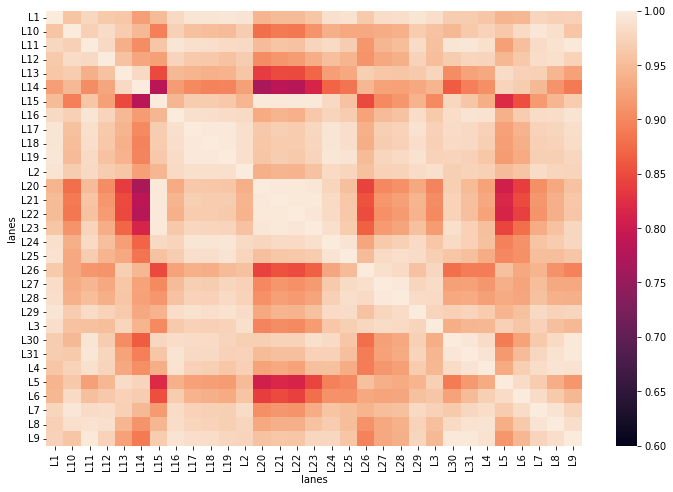

In [ ]:
fig,ax = plt.subplots(figsize=(12,8))
sns.heatmap(ery.T.corr(),cmap="rocket", vmin=0.6, vmax=1)

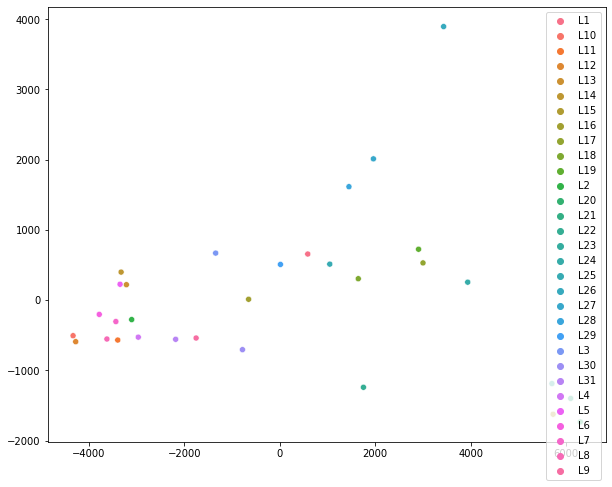

In [ ]:
pca = PCA(n_components=2)
X_2D = pca.fit_transform(ery)

fig, ax = plt.subplots(figsize=(10, 8))
sns.scatterplot(x= X_2D[:,0],y = X_2D[:,1],hue=ery.index)
plt.legend(loc='upper right')
plt.show()

It seems that erytrocytes are spread with different genes expression. Maybe, it is best to remove some cells and genes outliers and normalize the data.

# Data normalization

To avoid technical variability, data normalization is crucial. In this paper Normalization Methods on Single-Cell RNA-seq Data: An Empirical Survey by Lytal Nicholas, Ran Di, An Lingling https://www.frontiersin.org/articles/10.3389/fgene.2020.00041/full, they showed that although there exist some interesting normalization pipelines, a simple log2 transform (Seurat normalization) can also do a good job and no significative differences in pipelines draw attention in separating celltypes from six different scRNA-seq dataset. 

Also https://www.biorxiv.org/content/10.1101/2021.06.24.449781v3 agreed that simple log(x+1) transformation of data solves most of problems. 

According to https://www.nature.com/articles/ncomms14049#Sec11: 

"UMI normalization was performed by first dividing UMI counts by the total UMI counts in each cell, followed by multiplication with the median of the total UMI counts across cells. Then, we took the natural log of the UMI counts. *Finally, each gene was normalized such that the mean signal for each gene is 0, and standard deviation is 1.* "

The last part may not be interesting as we do not want to interfere in the differential gene expression between cells which is part of what we expecte an AutoEncoder to capture as pattern to clustering  

First, is commonly necessary to normalize the UMI counts of each cell so we compare concentrations of gene expression and not raw counts. Raw counts have the additional issue of technical variability, therefore should be avoided. 

In [ ]:
umi = sc.read_csv("/content/drive/MyDrive/AutoEncoder_HSC/GSE149938_umi_matrix.csv")

/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


It seems that are some genes duplicated in our dataset:

In [ ]:
# 7643 cells with 19813 genes umi counts 
umi

AnnData object with n_obs × n_vars = 7643 × 19813

## Repeated genes 

In [ ]:
repeat_genes = umi.var_names[umi.var_names.duplicated(keep=False)].unique()
repeat_genes

Index(['FAM231C', 'PIK3R3', 'ATRIP', 'CFAP99', 'MATR3', 'ECSCR', 'BLOC1S5',
       'PRICKLE4', 'RABL6', 'TIMM10B', 'C11orf71', 'AKR1C3', 'CCDC7', 'TMBIM4',
       'SERPINA3', 'TMEM256-PLSCR3', 'TBC1D26', 'CRHR1', 'FBF1', 'CAPS'],
      dtype='object')

In [ ]:
umi.to_df()[umi.to_df()['PIK3R3'].iloc[:,0] > 0]['PIK3R3']

PIK3R3  PIK3R3
BNK_spBM1_L1_bar32     16.0     0.0
BNK_spBM1_L3_bar79      1.0     0.0
BNK_spBM1_L4_bar89     14.0     0.0
BNK_spBM1_L4_bar90      2.0     0.0
BNK_spBM2_L8_bar7       1.0     0.0
...                     ...     ...
regB_bBM1_L26_bar52     1.0     0.0
regB_bBM1_L26_bar56     6.0     0.0
regB_bBM1_L27_bar67     6.0     0.0
regB_bBM1_L27_bar76     4.0     0.0
regB_bBM1_L27_bar77     1.0     0.0

[254 rows x 2 columns]

In [ ]:
(umi.to_df()['PIK3R3'].iloc[:,0] > 0).sum()

254

In [ ]:
umi_df = umi.to_df()
repeat_list = []
for gene in repeat_genes:
  repeat = umi_df[gene]
  umi_df.drop(gene, axis=1,inplace=True)
  print(f'gene: {gene}, num of entries with count > 0: {(repeat.iloc[:,0] > 0).sum()}, {(repeat.iloc[:,1] > 0).sum()}')
  if (repeat.iloc[:,0] > 0).sum() >= (repeat.iloc[:,1] > 0).sum():
    repeat_list.append(repeat.iloc[:,0])
  else:
    repeat_list.append(repeat.iloc[:,1])

repeat_list.append(umi_df)
umi_df = pd.concat(repeat_list, axis=1)

gene: FAM231C, num of entries with count > 0: 2, 4
gene: PIK3R3, num of entries with count > 0: 254, 0
gene: ATRIP, num of entries with count > 0: 6, 31
gene: CFAP99, num of entries with count > 0: 8, 0
gene: MATR3, num of entries with count > 0: 360, 1384
gene: ECSCR, num of entries with count > 0: 0, 11
gene: BLOC1S5, num of entries with count > 0: 1704, 0
gene: PRICKLE4, num of entries with count > 0: 827, 12
gene: RABL6, num of entries with count > 0: 1300, 0
gene: TIMM10B, num of entries with count > 0: 1930, 7
gene: C11orf71, num of entries with count > 0: 1014, 0
gene: AKR1C3, num of entries with count > 0: 3378, 0
gene: CCDC7, num of entries with count > 0: 571, 181
gene: TMBIM4, num of entries with count > 0: 4643, 0
gene: SERPINA3, num of entries with count > 0: 21, 16
gene: TMEM256-PLSCR3, num of entries with count > 0: 205, 5
gene: TBC1D26, num of entries with count > 0: 0, 20
gene: CRHR1, num of entries with count > 0: 1, 2
gene: FBF1, num of entries with count > 0: 598, 0

In [ ]:
umi_df.shape

(7643, 19793)

**We reconstruct the umi matrix without repeats, where the gene column kept were the one with the most counts higher than 0 (across cells)**

In [ ]:
#umi_df.to_csv("/content/drive/MyDrive/AutoEncoder_HSC/GSE149938_umi_matrix_deduplicated.csv")

In [ ]:
sc.settings.set_figure_params(dpi=80, facecolor="white")

## Filtering

In [ ]:
umi = sc.read_csv("/content/drive/MyDrive/AutoEncoder_HSC/GSE149938_umi_matrix_deduplicated.csv")

In [ ]:
sc.pp.filter_cells(umi, min_genes=300)
sc.pp.filter_genes(umi, min_cells=3)

filtered out 1301 genes that are detected in less than 3 cells


In [ ]:
umi.var_names[umi.var_names.str.startswith('MT-')]   #no mitochondrial genes?

Index([], dtype='object')

## QC

In [ ]:
sc.pp.calculate_qc_metrics(umi, percent_top=False, log1p=True,inplace=True)

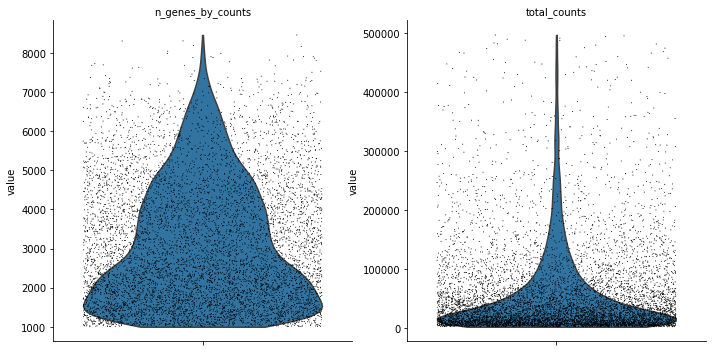

In [ ]:
sc.pl.violin(umi, ['n_genes_by_counts', 'total_counts'], jitter=0.4, multi_panel=True)

In [ ]:
umi.obs.head()

n_genes  n_genes_by_counts  log1p_n_genes_by_counts  \
BNK_spBM1_L1_bar25     1869               1868                 7.533159   
BNK_spBM1_L1_bar26     2050               2050                 7.626083   
BNK_spBM1_L1_bar27     3872               3872                 8.261785   
BNK_spBM1_L1_bar28     1475               1475                 7.297091   
BNK_spBM1_L1_bar29     2086               2086                 7.643483   

                    total_counts  log1p_total_counts  
BNK_spBM1_L1_bar25       24493.0           10.106183  
BNK_spBM1_L1_bar26       61974.0           11.034487  
BNK_spBM1_L1_bar27      124382.0           11.731121  
BNK_spBM1_L1_bar28        8144.0            9.005159  
BNK_spBM1_L1_bar29       53612.0           10.889546

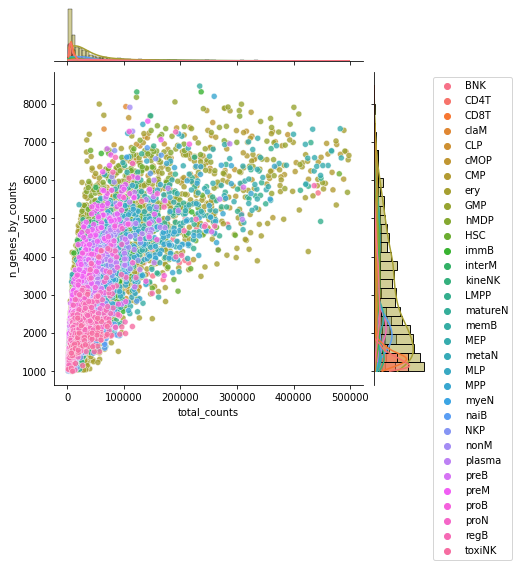

In [ ]:
names = umi.obs_names.to_series().apply(lambda x: x.split("_")[0])

g = sns.JointGrid(data=umi.obs, x="total_counts", y="n_genes_by_counts", hue=names)
g.plot_joint(sns.scatterplot, alpha=0.8)
g.plot_marginals(sns.histplot, kde=True)

sns.move_legend(g.ax_joint, "upper right", bbox_to_anchor=(1.5, 1))
#plt.legend(names.unique(), bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()


In [ ]:
umi.obs['celltype'] =  umi.obs_names.to_series().apply(lambda x: x.split("_")[0])

**under construction: create each scatterplot separately by celltype**

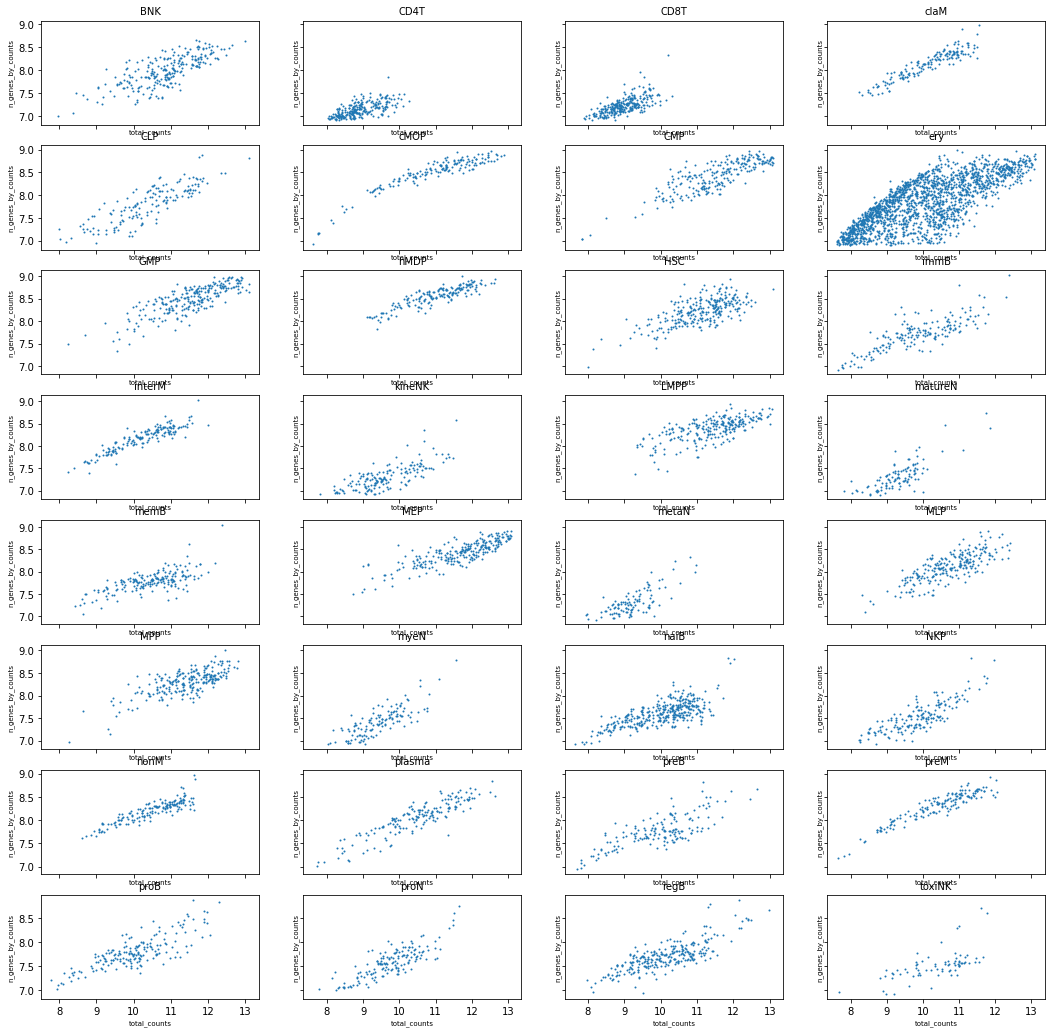

In [ ]:
fig, axes = plt.subplots(8, 4, figsize=(18,18),sharex='col', sharey='row')
#g = sns.FacetGrid(umi.obs, hue=umi.obs['celltype'])
i = 0
j = 0
for cell in umi.obs['celltype'].unique():
  if i == 8:
    break 
  axes[i,j].scatter(data=umi.obs[umi.obs['celltype'] == cell], x="log1p_total_counts", y="log1p_n_genes_by_counts", s = 1)
  axes[i,j].set_ylabel('n_genes_by_counts',fontsize = 7) # Y label
  axes[i,j].set_xlabel('total_counts',fontsize = 7) # X label
  axes[i,j].tick_params(axis='both', which='major', labelsize=10)
  axes[i,j].set_title(cell, fontsize = 10)
  if j == 3:
    j = 0
    i += 1 
  else:
    j += 1
  
  
#sns.move_legend(g, "upper right", bbox_to_anchor=(1.5, 1))

plt.show()


Note: log1p = ln(1+x)

As it can be seem, ery are the cells with the most variability !

In [ ]:
# we pick data data range from lower to upper limit 
upper_lim = np.quantile(umi.obs.n_genes_by_counts.values, 0.98)
lower_lim = np.quantile(umi.obs.n_genes_by_counts.values, 0.02)
lower_lim, upper_lim

(1073.84, 6688.16)

In [ ]:
umi = umi[(umi.obs.n_genes_by_counts.values < upper_lim)]
umi

View of AnnData object with n_obs × n_vars = 7490 × 18492
    obs: 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'celltype'
    var: 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [ ]:
umi.X[0,:].sum()

ArrayView(24493., dtype=float32)

In [ ]:
# we create a layer to normalize as a copy of raw counts 
# so we can compare later the raw vs normalized ! 
umi.layers['normalized'] = umi.X

In [ ]:
sc.pp.normalize_total(umi, layer='normalized')

normalizing counts per cell
    finished (0:00:00)


In [ ]:
sc.pp.log1p(umi, layer='normalized')

In [ ]:
#umi.write("/content/drive/MyDrive/AutoEncoder_HSC/GSE149938_umi_matrix_deduplicated.anndata")

In [ ]:
umi = sc.read("/content/drive/MyDrive/AutoEncoder_HSC/GSE149938_umi_matrix_deduplicated.h5ad")
umi

AnnData object with n_obs × n_vars = 7490 × 18492
    obs: 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'celltype', 'lane'
    var: 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'celltype_colors', 'hvg', 'lane_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'normalized'
    obsp: 'connectivities', 'distances'

# Clustering 

Clustering can also give good evidences of batch-effect. 

In [ ]:
umi = sc.read("/content/drive/MyDrive/AutoEncoder_HSC/GSE149938_umi_matrix_deduplicated.h5ad", cache=True)

In [ ]:
umi.uns['log1p']['base'] = None

In [ ]:
# cannot do seurat_v3 preprocesisng as expectes raw counts 
# we have log normalized data now...
#sc.pp.highly_variable_genes(umi, flavor='seurat_v3', n_top_genes=2000)
sc.pp.highly_variable_genes(umi, min_mean=0.0125, max_mean =3, min_disp=0.5, layer='normalized')

extracting highly variable genes
    finished (0:00:05)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [ ]:
umi.var[umi.var.highly_variable]

n_cells  n_cells_by_counts  mean_counts  log1p_mean_counts  \
MATR3        1384               1384     1.666754           0.980862   
ISG15        2201               2201     3.168389           1.427530   
TNFRSF18      338                338     0.359021           0.306765   
TNFRSF4       230                230     0.255397           0.227452   
ACAP3        1106               1106     0.936805           0.661040   
...           ...                ...          ...                ...   
PCBP3         490                490     0.455319           0.375225   
FTCD           32                 32     0.011775           0.011707   
C21orf58     2558               2558     6.090802           1.958799   
DIP2A        3096               3096     4.274761           1.662933   
S100B         201                201     0.203585           0.185305   

          pct_dropout_by_counts  total_counts  log1p_total_counts  \
MATR3                 81.891927       12739.0            9.452502   
ISG15                 71.202407       24216.0           10.094810   
TNFRSF18              95.577653        2744.0            7.917536   
TNFRSF4               96.990710        1952.0            7.577122   
ACAP3                 85.529242        7160.0            8.876405   
...                         ...           ...                 ...   
PCBP3                 93.588905        3480.0            8.155075   
FTCD                  99.581316          90.0            4.510859   
C21orf58              66.531467       46552.0           10.748346   
DIP2A                 59.492346       32672.0           10.394304   
S100B                 97.370143        1556.0            7.350516   

          highly_variable     means  dispersions  dispersions_norm  
MATR3                True  0.688464     2.962435          0.617055  
ISG15                True  1.103915     3.250641          1.238389  
TNFRSF18             True  0.240048     3.016130          0.766261  
TNFRSF4              True  0.142349     2.775474          0.502680  
ACAP3                True  0.476712     2.967649          0.820381  
...                   ...       ...          ...               ...  
PCBP3                True  0.169516     3.173555          0.938683  
FTCD                 True  0.012852     3.226301          0.996454  
C21orf58             True  1.197253     3.343232          1.465279  
DIP2A                True  1.469758     3.469956          1.174970  
S100B                True  0.261108     4.302904          2.175616  

[4089 rows x 11 columns]

In [ ]:
# same calculation, as base = None results in np.e computed 
#umi.uns['log1p']['base'] = np.e
#sc.pp.highly_variable_genes(umi, min_mean=0.0125, max_mean =3, min_disp=0.5, layer='normalized')
#umi.var[umi.var.highly_variable].head()

extracting highly variable genes
    finished (0:00:03)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


n_cells  n_cells_by_counts  mean_counts  log1p_mean_counts  \
MATR3        1384               1384     1.666754           0.980862   
ISG15        2201               2201     3.168389           1.427530   
TNFRSF18      338                338     0.359021           0.306765   
TNFRSF4       230                230     0.255397           0.227452   
ACAP3        1106               1106     0.936805           0.661040   
...           ...                ...          ...                ...   
PCBP3         490                490     0.455319           0.375225   
FTCD           32                 32     0.011775           0.011707   
C21orf58     2558               2558     6.090802           1.958799   
DIP2A        3096               3096     4.274761           1.662933   
S100B         201                201     0.203585           0.185305   

          pct_dropout_by_counts  total_counts  log1p_total_counts  \
MATR3                 81.891927       12739.0            9.452502   
ISG15                 71.202407       24216.0           10.094810   
TNFRSF18              95.577653        2744.0            7.917536   
TNFRSF4               96.990710        1952.0            7.577122   
ACAP3                 85.529242        7160.0            8.876405   
...                         ...           ...                 ...   
PCBP3                 93.588905        3480.0            8.155075   
FTCD                  99.581316          90.0            4.510859   
C21orf58              66.531467       46552.0           10.748346   
DIP2A                 59.492346       32672.0           10.394304   
S100B                 97.370143        1556.0            7.350516   

          highly_variable     means  dispersions  dispersions_norm  
MATR3                True  0.688464     2.962435          0.617055  
ISG15                True  1.103915     3.250641          1.238389  
TNFRSF18             True  0.240048     3.016130          0.766261  
TNFRSF4              True  0.142349     2.775474          0.502680  
ACAP3                True  0.476712     2.967649          0.820381  
...                   ...       ...          ...               ...  
PCBP3                True  0.169516     3.173555          0.938683  
FTCD                 True  0.012852     3.226301          0.996454  
C21orf58             True  1.197253     3.343232          1.465279  
DIP2A                True  1.469758     3.469956          1.174970  
S100B                True  0.261108     4.302904          2.175616  

[4089 rows x 11 columns]

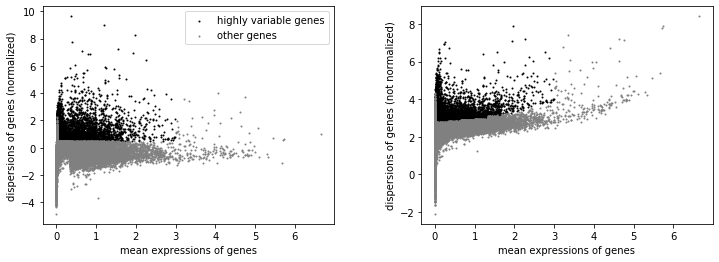

In [ ]:
sc.pl.highly_variable_genes(umi)   # do the same as below, but without customizations :(

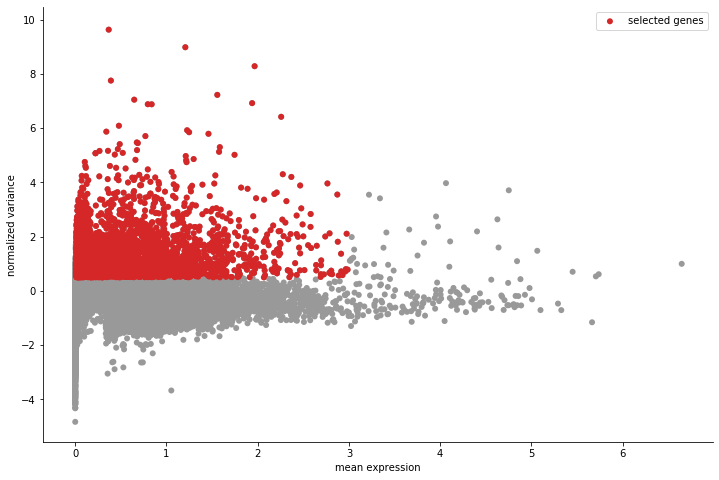

In [ ]:
fig, ax = plt.subplots(1,figsize=(12, 8))
hvgs = umi.var["highly_variable"]

ax.scatter(umi.var["means"], umi.var["dispersions_norm"],  edgecolor="none", c='0.6')
ax.scatter(umi.var["means"][hvgs],umi.var["dispersions_norm"][hvgs],c="tab:red",
label="selected genes",edgecolor="none")


ax.set_xlabel("mean expression")
ax.set_ylabel("normalized variance")
#ax.set_title(adata.uns["name"])
#ax.set_yscale('log')
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")
#ax.set_xlim([0, 200])
#ax.set_ylim([0, 100])
plt.legend()

**Should we filter out those genes with low mean counts (near zero) ?**

Does mean counts of genes near zero is noise or highly specific to cells ?

### Do we have batch effect ? PCA not regressed vs PCA regress out 

In [ ]:
# creating a column of lanes 
umi.obs['lane'] = umi.obs_names.to_series().apply(lambda x: x.split("_")[2]) 

Let's change the X data to the normalized one and save a raw with the X unnormalized. That's because PCA is not accepting a layer parameter, so it will process in the X "raw" data instead of normalized !

In [ ]:
umi.raw = umi
umi.X = umi.layers['normalized']

In [ ]:
umi.X[50:55,:5] , umi.raw.X[50:55,:5]

(array([[0.       , 0.       , 0.       , 0.       , 0.       ],
        [0.       , 0.       , 0.       , 0.       , 2.5834072],
        [0.       , 0.       , 0.       , 0.       , 1.6197706],
        [0.       , 1.8575053, 0.       , 0.       , 2.9920788],
        [0.       , 2.0894594, 0.       , 0.       , 1.5129871]],
       dtype=float32), array([[ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0., 19.],
        [ 0.,  0.,  0.,  0.,  2.],
        [ 0., 14.,  0.,  0., 49.],
        [ 0.,  2.,  0.,  0.,  1.]], dtype=float32))

In [ ]:
sc.tl.pca(umi, use_highly_variable=True,n_comps=80)

computing PCA
    on highly variable genes
    with n_comps=80
    finished (0:00:09)


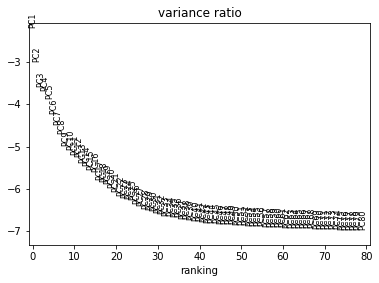

In [ ]:
sc.pl.pca_variance_ratio(umi, log=True, n_pcs=80)

It seems that with 40 to 50 PCs we still gain information about data...but then the variance ratio become flat

It also worth mentioning that it seems the case that with SC RNA-seq, we tend to have a cumulative variance explained about 30% with around 50 PCs (see: )


In [ ]:
# cumulative explained variance
umi.uns['pca']['variance_ratio'].sum(), umi.uns['pca']['variance_ratio'][:40].sum(), umi.uns['pca']['variance_ratio'][:50].sum()

(0.3944438, 0.3536366, 0.3647147)

The figure below shows the most important loading (genes) and least important according to each PC. Only the three first PCs are shown.  

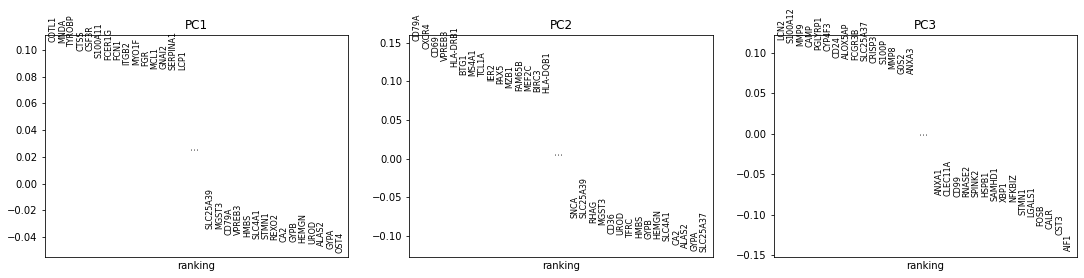

In [ ]:
sc.pl.pca_loadings(umi)

According to PC1, one of the most important genes is SERPINA1. Let's check the description of it according to genecards domain:

*The protein encoded by this gene is a serine protease inhibitor belonging to the serpin superfamily whose targets include elastase, plasmin, thrombin, trypsin, chymotrypsin, and plasminogen activator. **This protein is produced in the liver, the bone marrow, by lymphocytic and monocytic cells in lymphoid tissue, and by the Paneth cells of the gut.** Defects in this gene are associated with chronic obstructive pulmonary disease, emphysema, and chronic liver disease. Several transcript variants encoding the same protein have been found for this gene. [provided by RefSeq, Aug 2020]*

Source: https://www.genecards.org/cgi-bin/carddisp.pl?gene=SERPINA1

We input PCA components to a UMAP in order to visualize clusters.

UMAP needs some parameters (from https://pair-code.github.io/understanding-umap/) 

The most important parameter is **n_neighbors** - the number of approximate nearest neighbors used to construct the initial high-dimensional graph. It effectively controls how UMAP balances local versus global structure - low values will push UMAP to focus more on local structure by constraining the number of neighboring points considered when analyzing the data in high dimensions, while high values will push UMAP towards representing the big-picture structure while losing fine detail.

The second parameter we’ll investigate is **min_dist,** or the minimum distance between points in low-dimensional space. This parameter controls how tightly UMAP clumps points together, with low values leading to more tightly packed embeddings. Larger values of min_dist will make UMAP pack points together more loosely, focusing instead on the preservation of the broad topological structure.

In [ ]:
sc.pp.neighbors(umi, n_neighbors=15, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:06)


In [ ]:
umi.obs['lane']

BNK_spBM1_L1_bar25         L1
BNK_spBM1_L1_bar26         L1
BNK_spBM1_L1_bar27         L1
BNK_spBM1_L1_bar28         L1
BNK_spBM1_L1_bar29         L1
                         ... 
toxiNK_nkPB2_L12_bar29    L12
toxiNK_nkPB2_L12_bar30    L12
toxiNK_nkPB2_L12_bar31    L12
toxiNK_nkPB2_L12_bar32    L12
toxiNK_nkPB2_L12_bar33    L12
Name: lane, Length: 7490, dtype: category
Categories (31, object): ['L1', 'L2', 'L3', 'L4', ..., 'L28', 'L29', 'L30', 'L31']

In [ ]:
sc.tl.umap(umi)

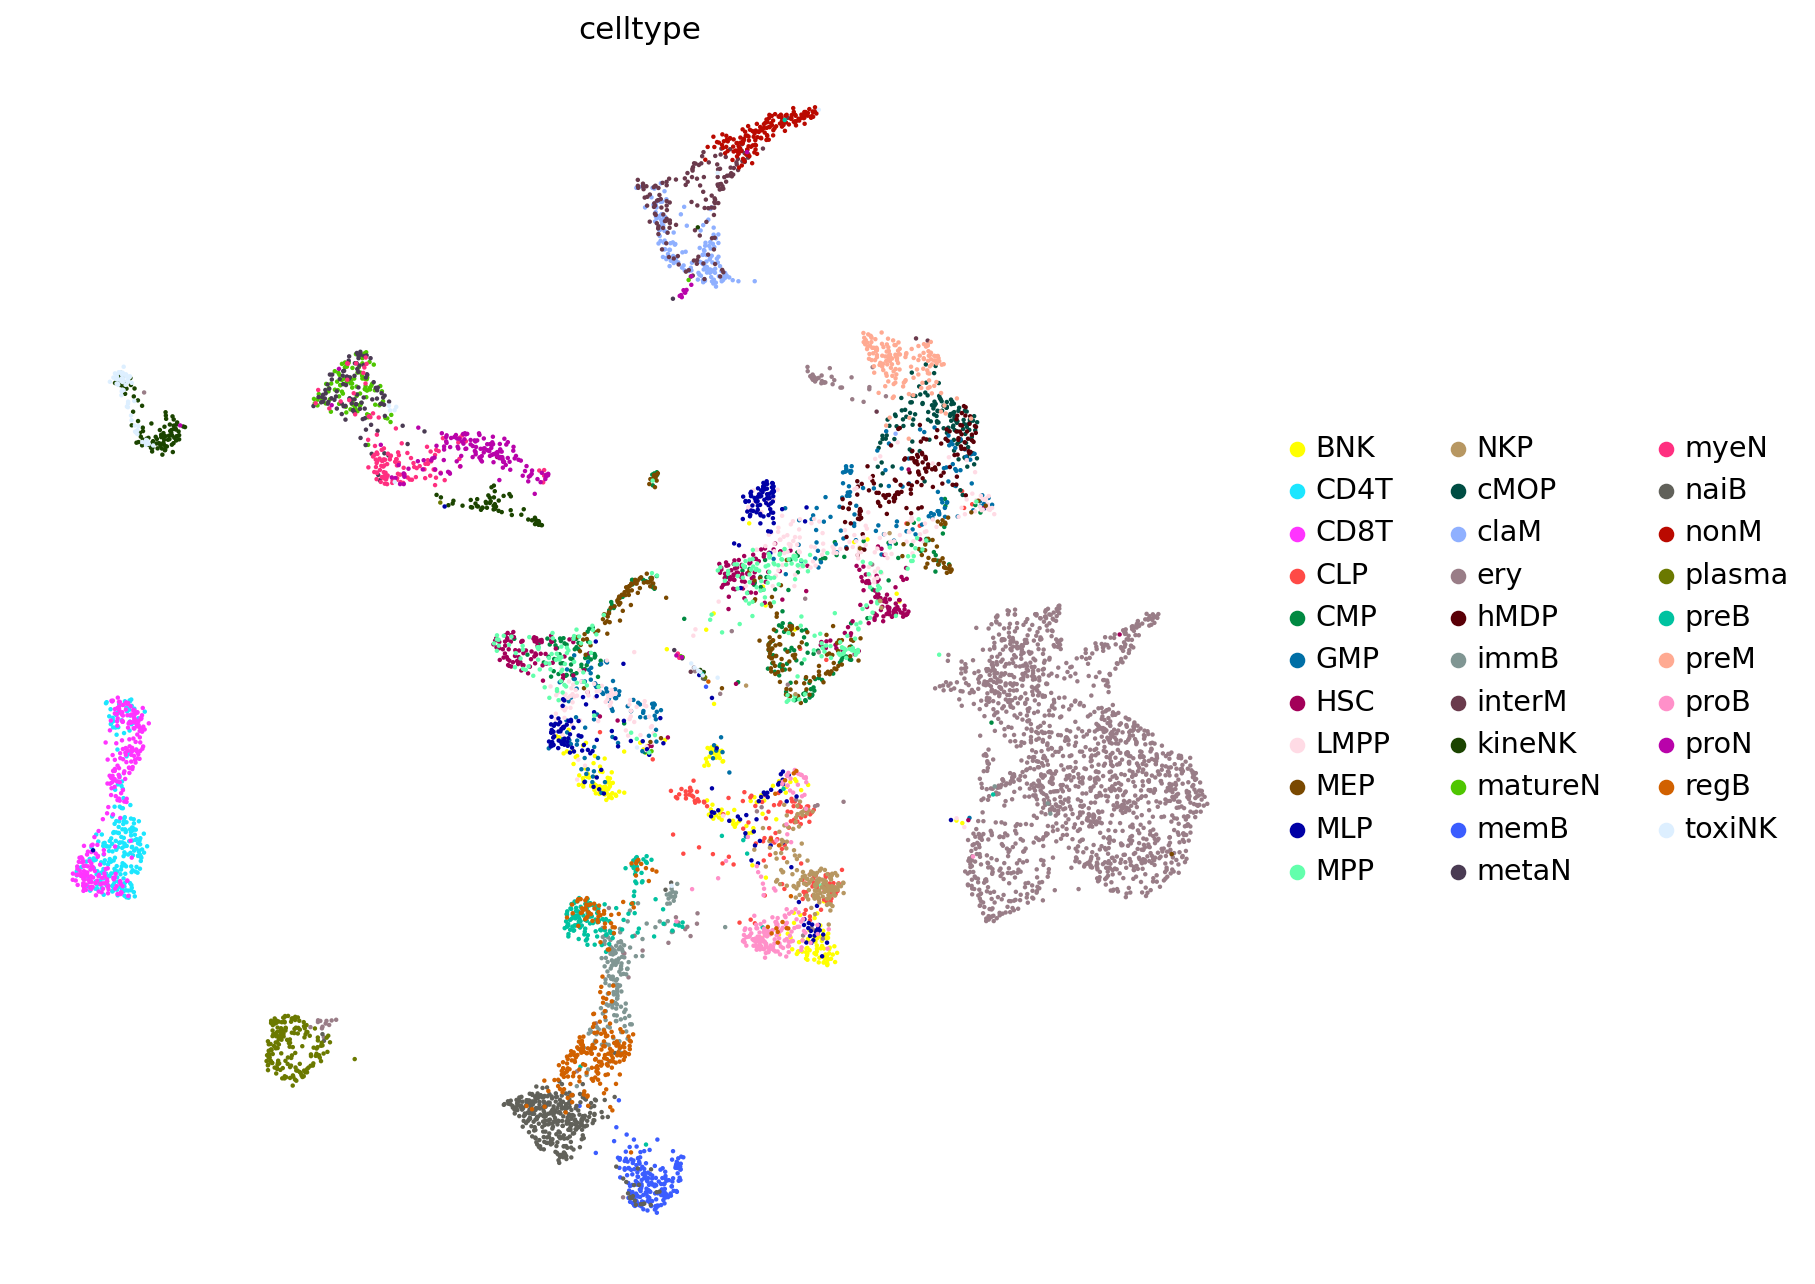

In [ ]:
sc.set_figure_params(figsize=(10,10))
sc.pl.umap(umi,use_raw=False,color='celltype', show=True, frameon=False)

We also plot the same UMAP but coloured by lanes to check for batch effects. 

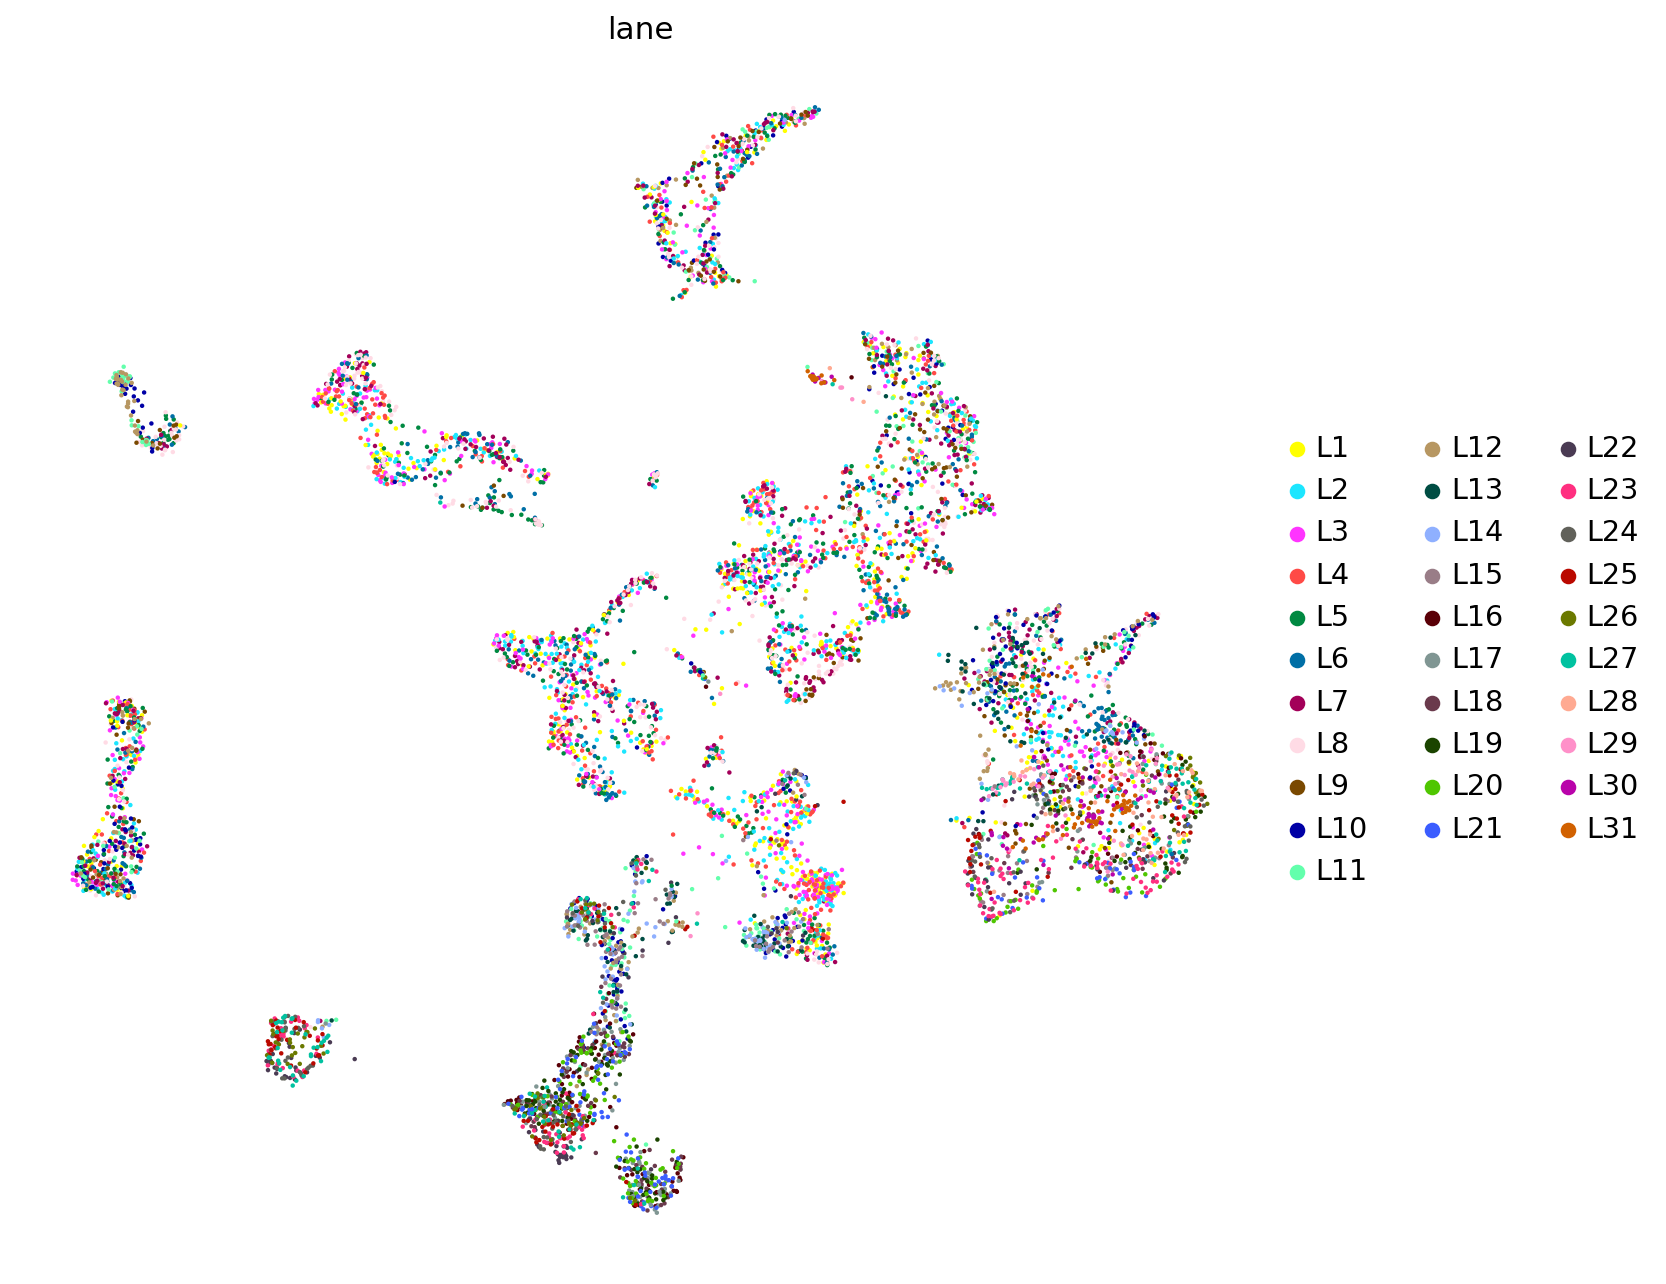

In [ ]:
sc.set_figure_params(figsize=(10,10))
sc.pl.umap(umi,use_raw=False,color='lane', show=True, frameon=False)

There is a little bit of clustering that maybe can be regressed out. But in general, data is more dispersed. 

In [ ]:
#umi.write("/content/drive/MyDrive/AutoEncoder_HSC/GSE149938_umi_matrix_deduplicated.h5ad")

In [ ]:
sc.pp.regress_out(umi,keys=['total_counts'])

regressing out ['total_counts']
    finished (0:02:45)


In [ ]:
umi.X

array([[-2.1653603e-04, -2.5340563e-02, -5.0271708e-03, ...,
        -4.0115644e-03, -3.1489212e-02, -4.4258737e-05],
       [-2.0087678e-04, -3.0746644e-02, -5.1200036e-03, ...,
        -5.5949395e-03, -3.0958457e-02, -9.1019327e-05],
       [-1.7480319e-04, -3.9748080e-02, -5.2745757e-03, ...,
         2.0683348e-01, -3.0074719e-02, -1.6887838e-04],
       ...,
       [-2.2357333e-04, -2.2911064e-02, -4.9854517e-03, ...,
        -3.2999944e-03, -3.1727735e-02, -2.3244478e-05],
       [-2.1328604e-04, -2.6462570e-02, -5.0464380e-03, ...,
        -4.3401862e-03, -3.1379055e-02, -5.3963671e-05],
       [-2.0839619e-04, -2.8150698e-02, -5.0754263e-03, ...,
        -4.8346189e-03, -3.1213319e-02, -6.8565365e-05]], dtype=float32)

computing PCA
    on highly variable genes
    with n_comps=40
    finished (0:00:03)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:22)


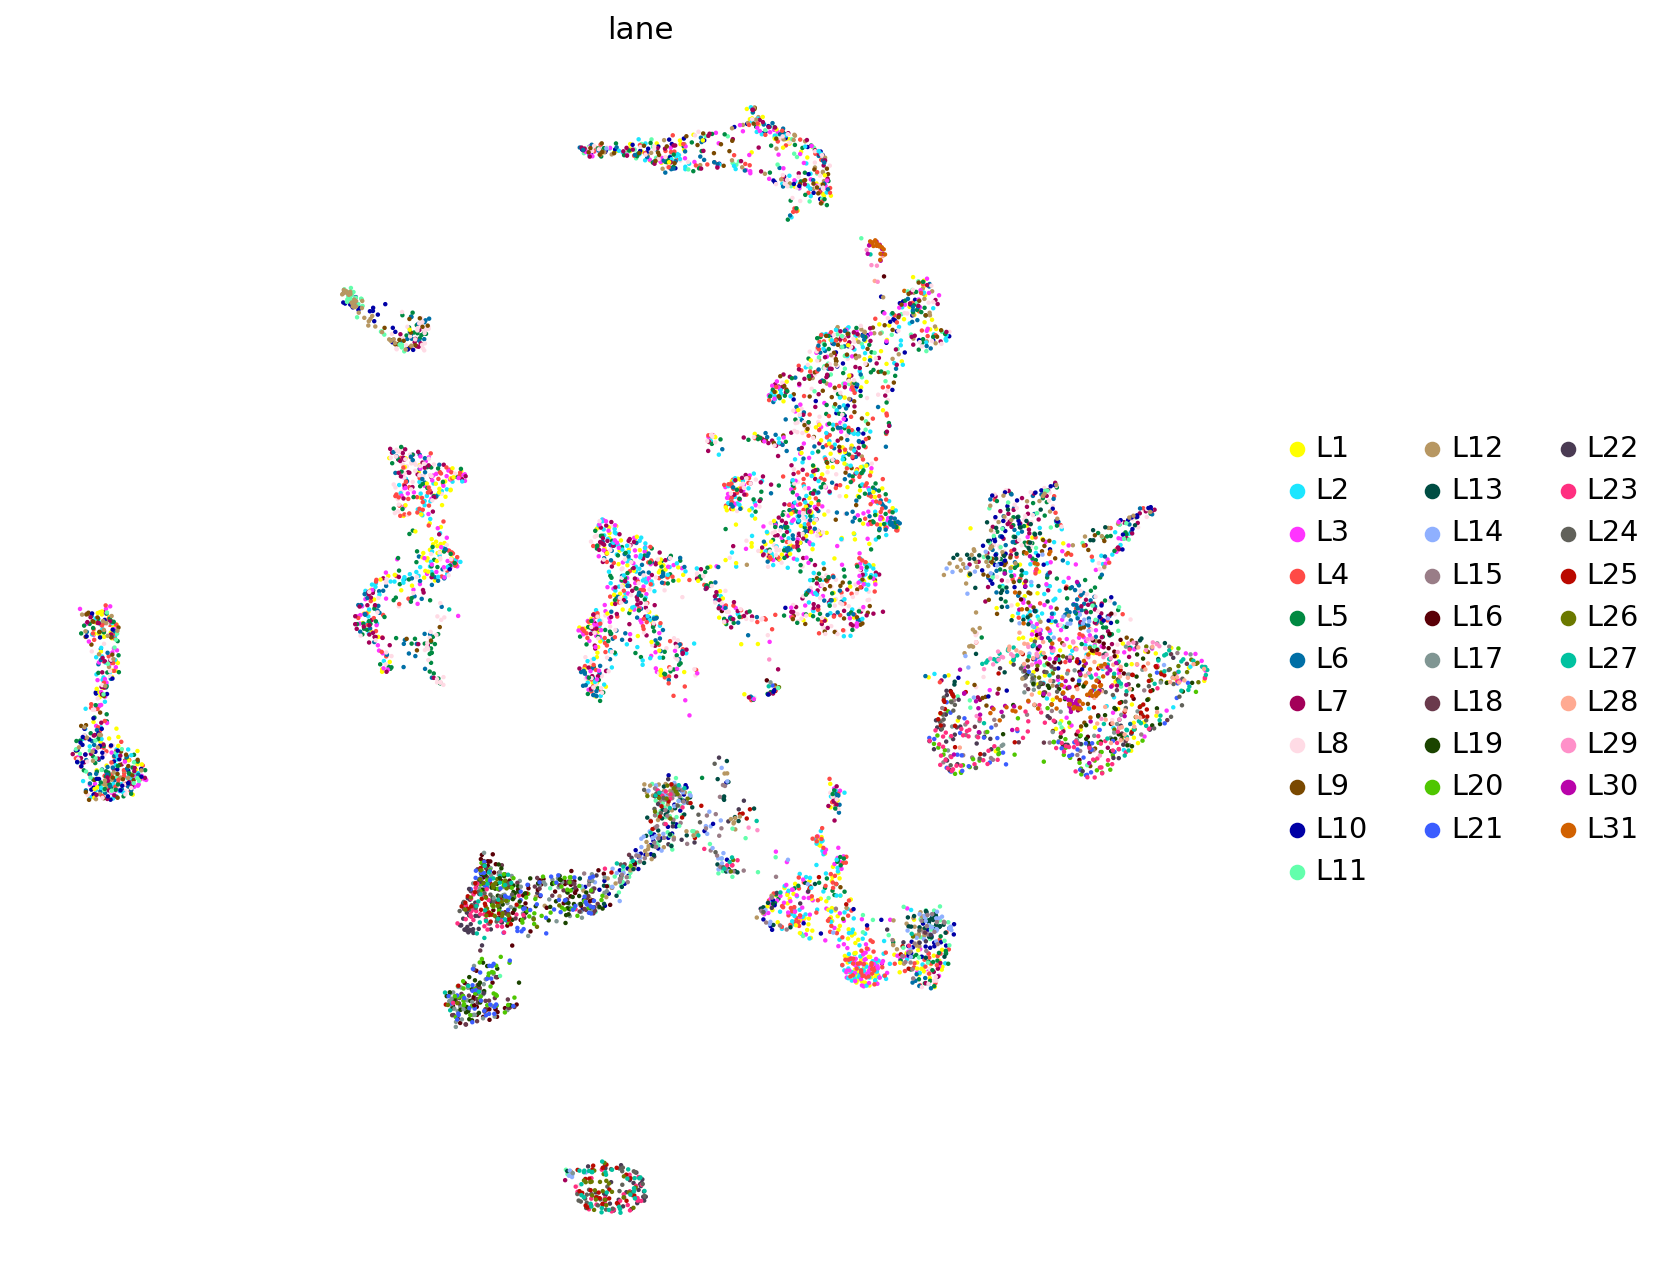

In [ ]:
sc.tl.pca(umi, use_highly_variable=True,n_comps=40)
sc.pp.neighbors(umi, n_neighbors=15, n_pcs=40)
sc.tl.umap(umi)
#sc.set_figure_params(figsize=(10,10))
sc.pl.umap(umi,use_raw=False,color='lane', show=True, frameon=False)

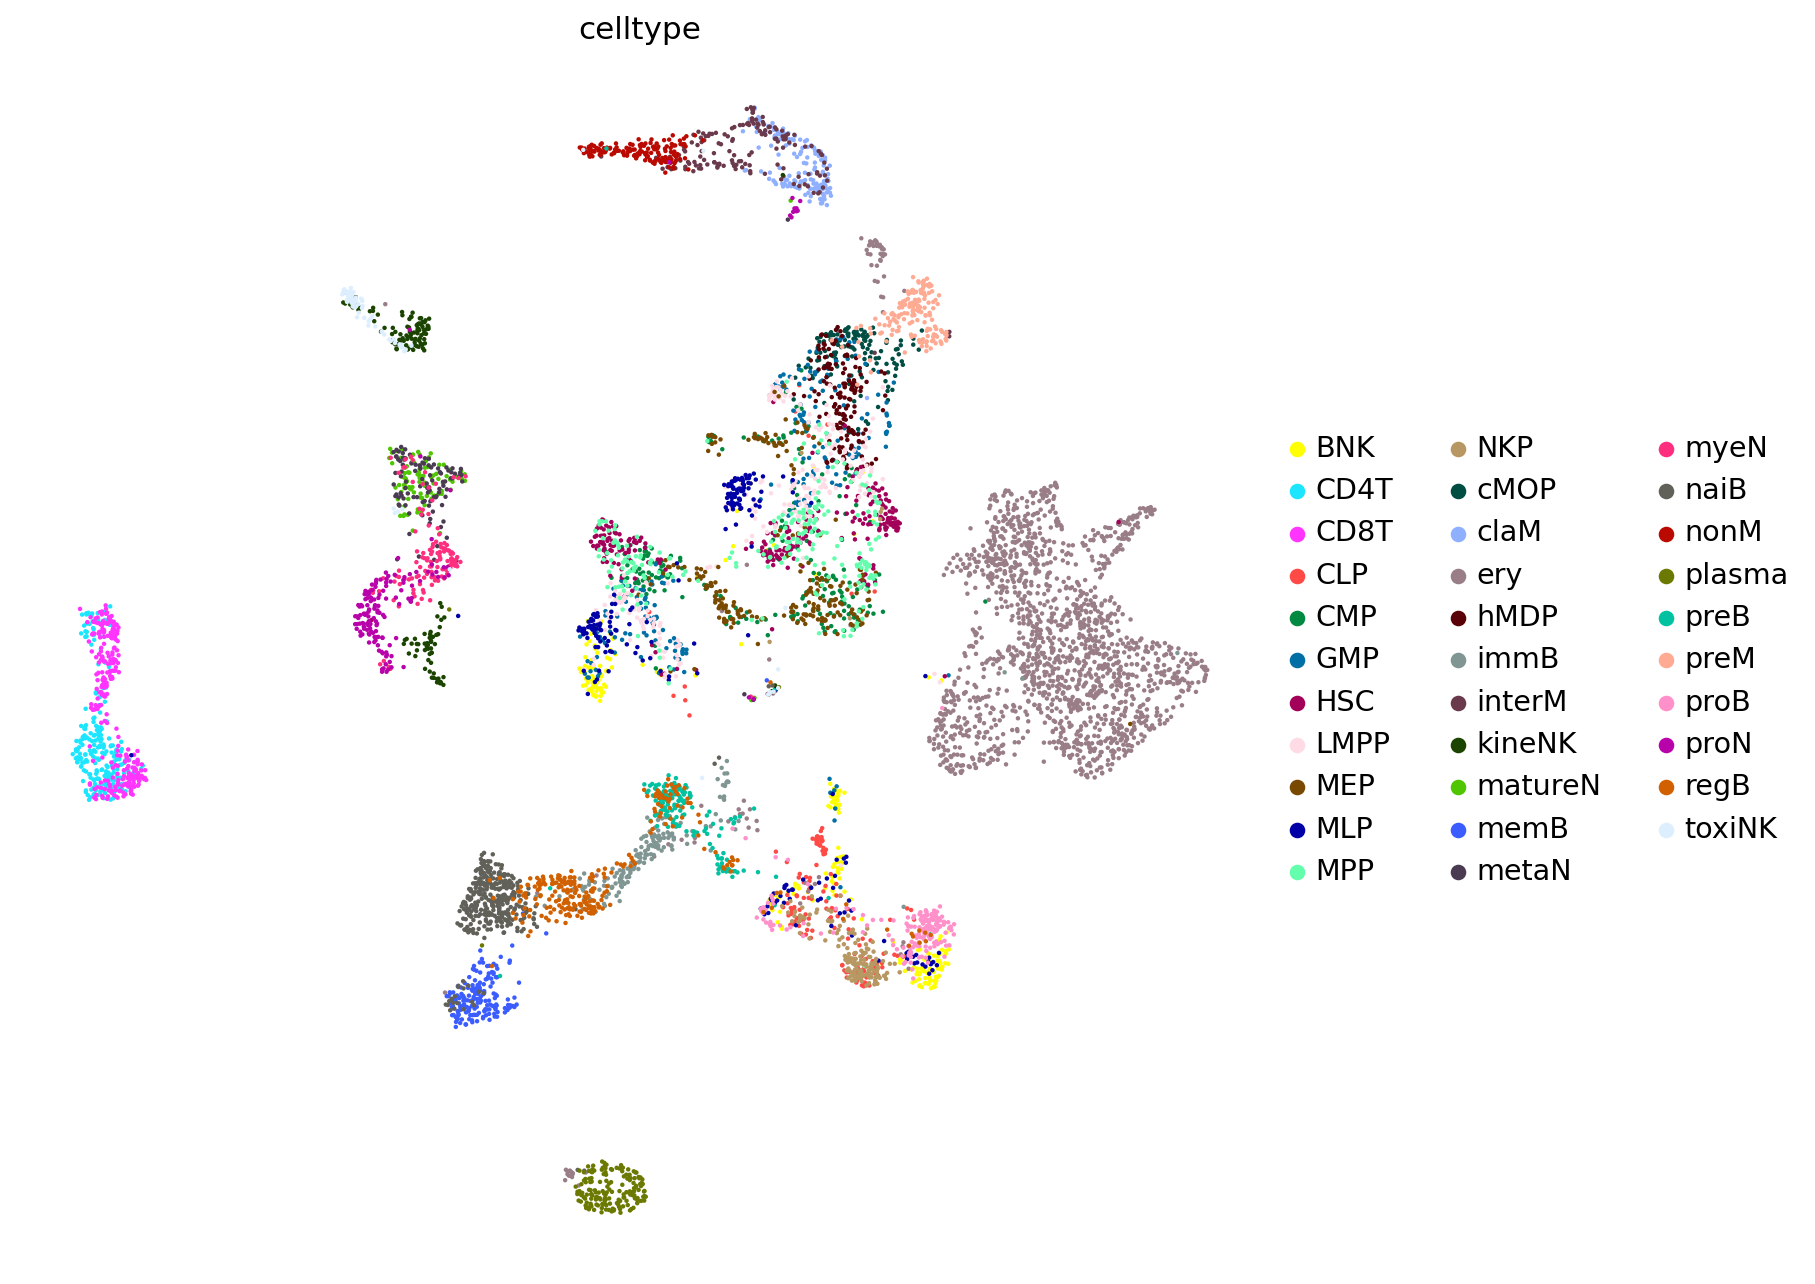

In [ ]:
sc.pl.umap(umi,use_raw=False,color='celltype', show=True, frameon=False)

It seems it improved celltype separability, although it is not that much of a difference...

In [ ]:
cells_dict = {
    'HSPC':['HSC','MPP', 'CMP', 'MEP', 'LMPP', 'MLP', 'BNK', 'GMP'],  #10% 
    'B':['proB','preB', 'immB','regB','naiB','memB','plasma'], #5%
    'Erythrocyte':['ery'], #2.5%
    'NK':['CLP','NKP','toxiNK','kineNK'],  #5%
    'T':['CD4T','CD8T'],   #2.5%
    'Monocyte':['hMDP','cMOP','preM','nonM','claM','interM'],   #10%
    'Neutrophil':['proN','myeN','matureN','metaN'] #2.5%
              }

In [ ]:
df = umi.obs.copy()

In [ ]:
cells = {}
for k,v in cells_dict.items():
  for ct in cells_dict[k]:
    cells[ct] = k

cells


{'HSC': 'HSPC',
 'MPP': 'HSPC',
 'CMP': 'HSPC',
 'MEP': 'HSPC',
 'LMPP': 'HSPC',
 'MLP': 'HSPC',
 'BNK': 'HSPC',
 'GMP': 'HSPC',
 'proB': 'B',
 'preB': 'B',
 'immB': 'B',
 'regB': 'B',
 'naiB': 'B',
 'memB': 'B',
 'plasma': 'B',
 'ery': 'Erythrocyte',
 'CLP': 'NK',
 'NKP': 'NK',
 'toxiNK': 'NK',
 'kineNK': 'NK',
 'CD4T': 'T',
 'CD8T': 'T',
 'hMDP': 'Monocyte',
 'cMOP': 'Monocyte',
 'preM': 'Monocyte',
 'nonM': 'Monocyte',
 'claM': 'Monocyte',
 'interM': 'Monocyte',
 'proN': 'Neutrophil',
 'myeN': 'Neutrophil',
 'matureN': 'Neutrophil',
 'metaN': 'Neutrophil'}

In [ ]:
umi.obs['cluster_cell'] = df['celltype'].replace(cells)

Figure below show that the UMAP clustering separated all cells by their origin type, as expected!

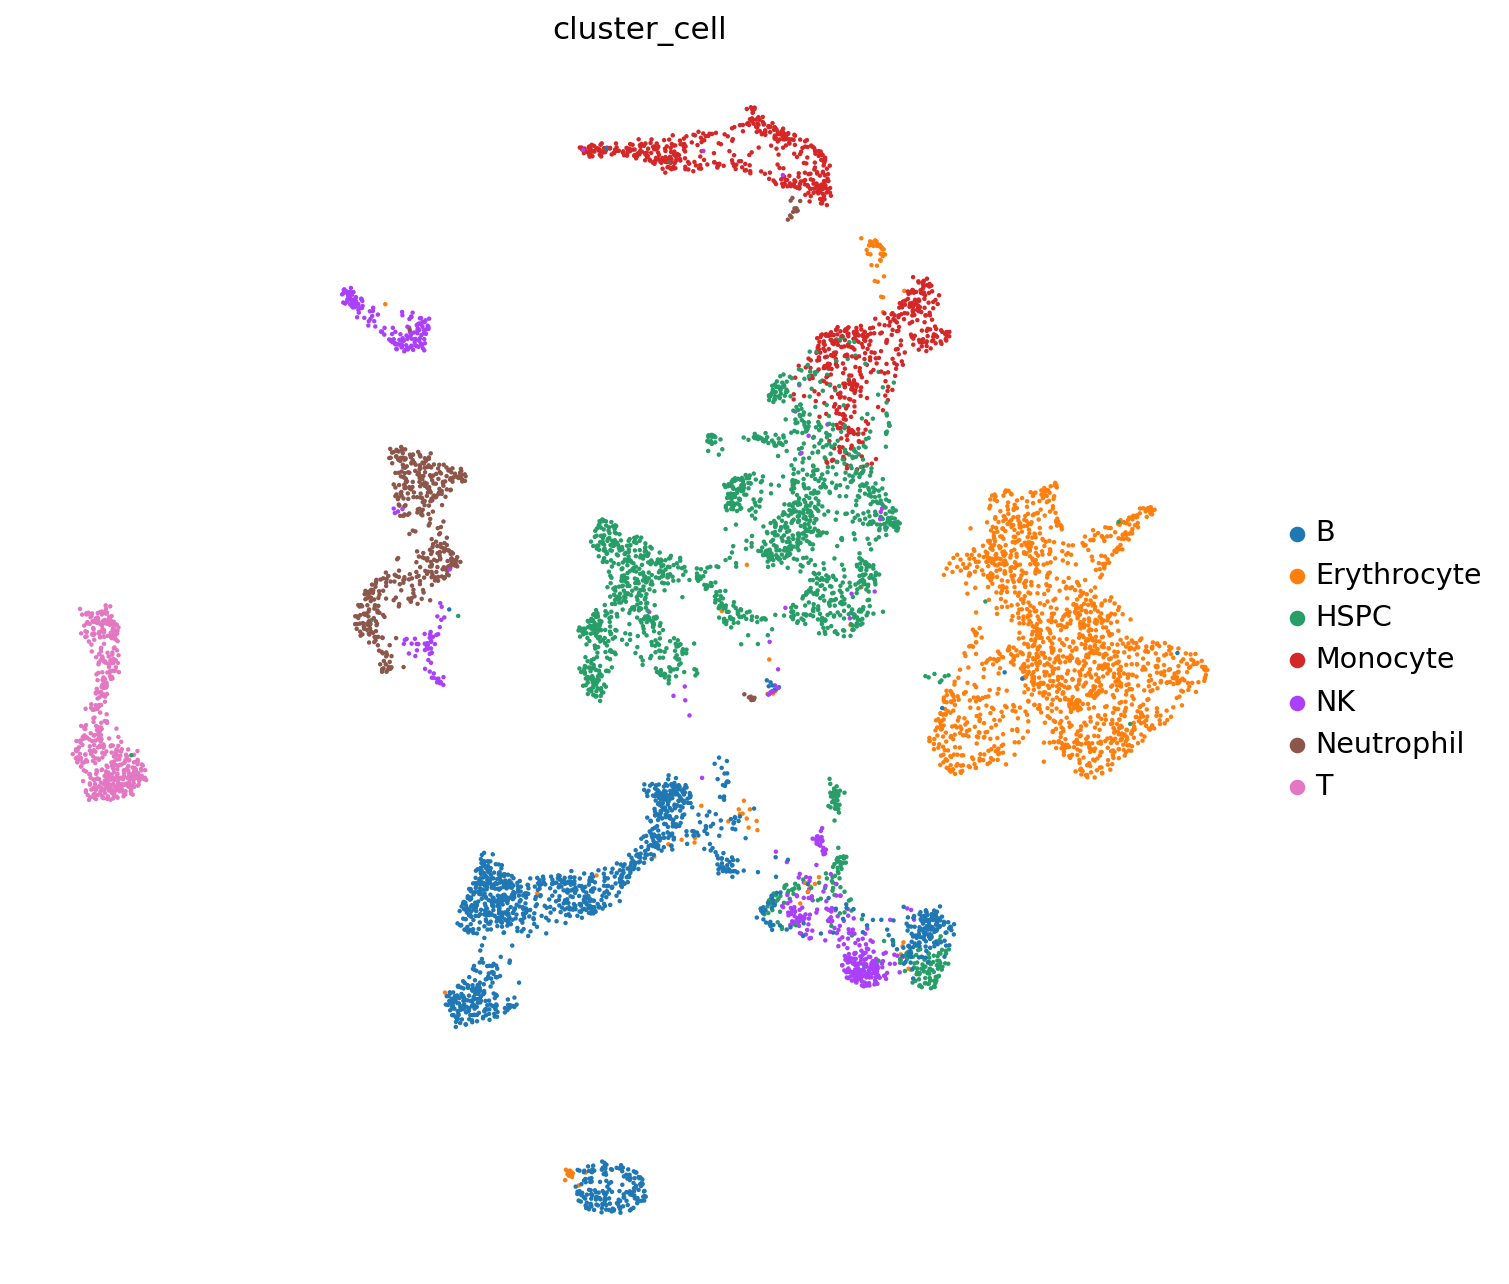

In [ ]:
sc.pl.umap(umi,use_raw=False,color='cluster_cell', show=True, frameon=False)

In [ ]:
#umi.write("/content/drive/MyDrive/AutoEncoder_HSC/GSE149938_umi_matrix_deduplicated_v2.h5ad")

# Finding Marker Genes

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:34)


/usr/local/lib/python3.7/dist-packages/scanpy/tools/_rank_genes_groups.py:421: RuntimeWarning: invalid value encountered in log2
  foldchanges[global_indices]


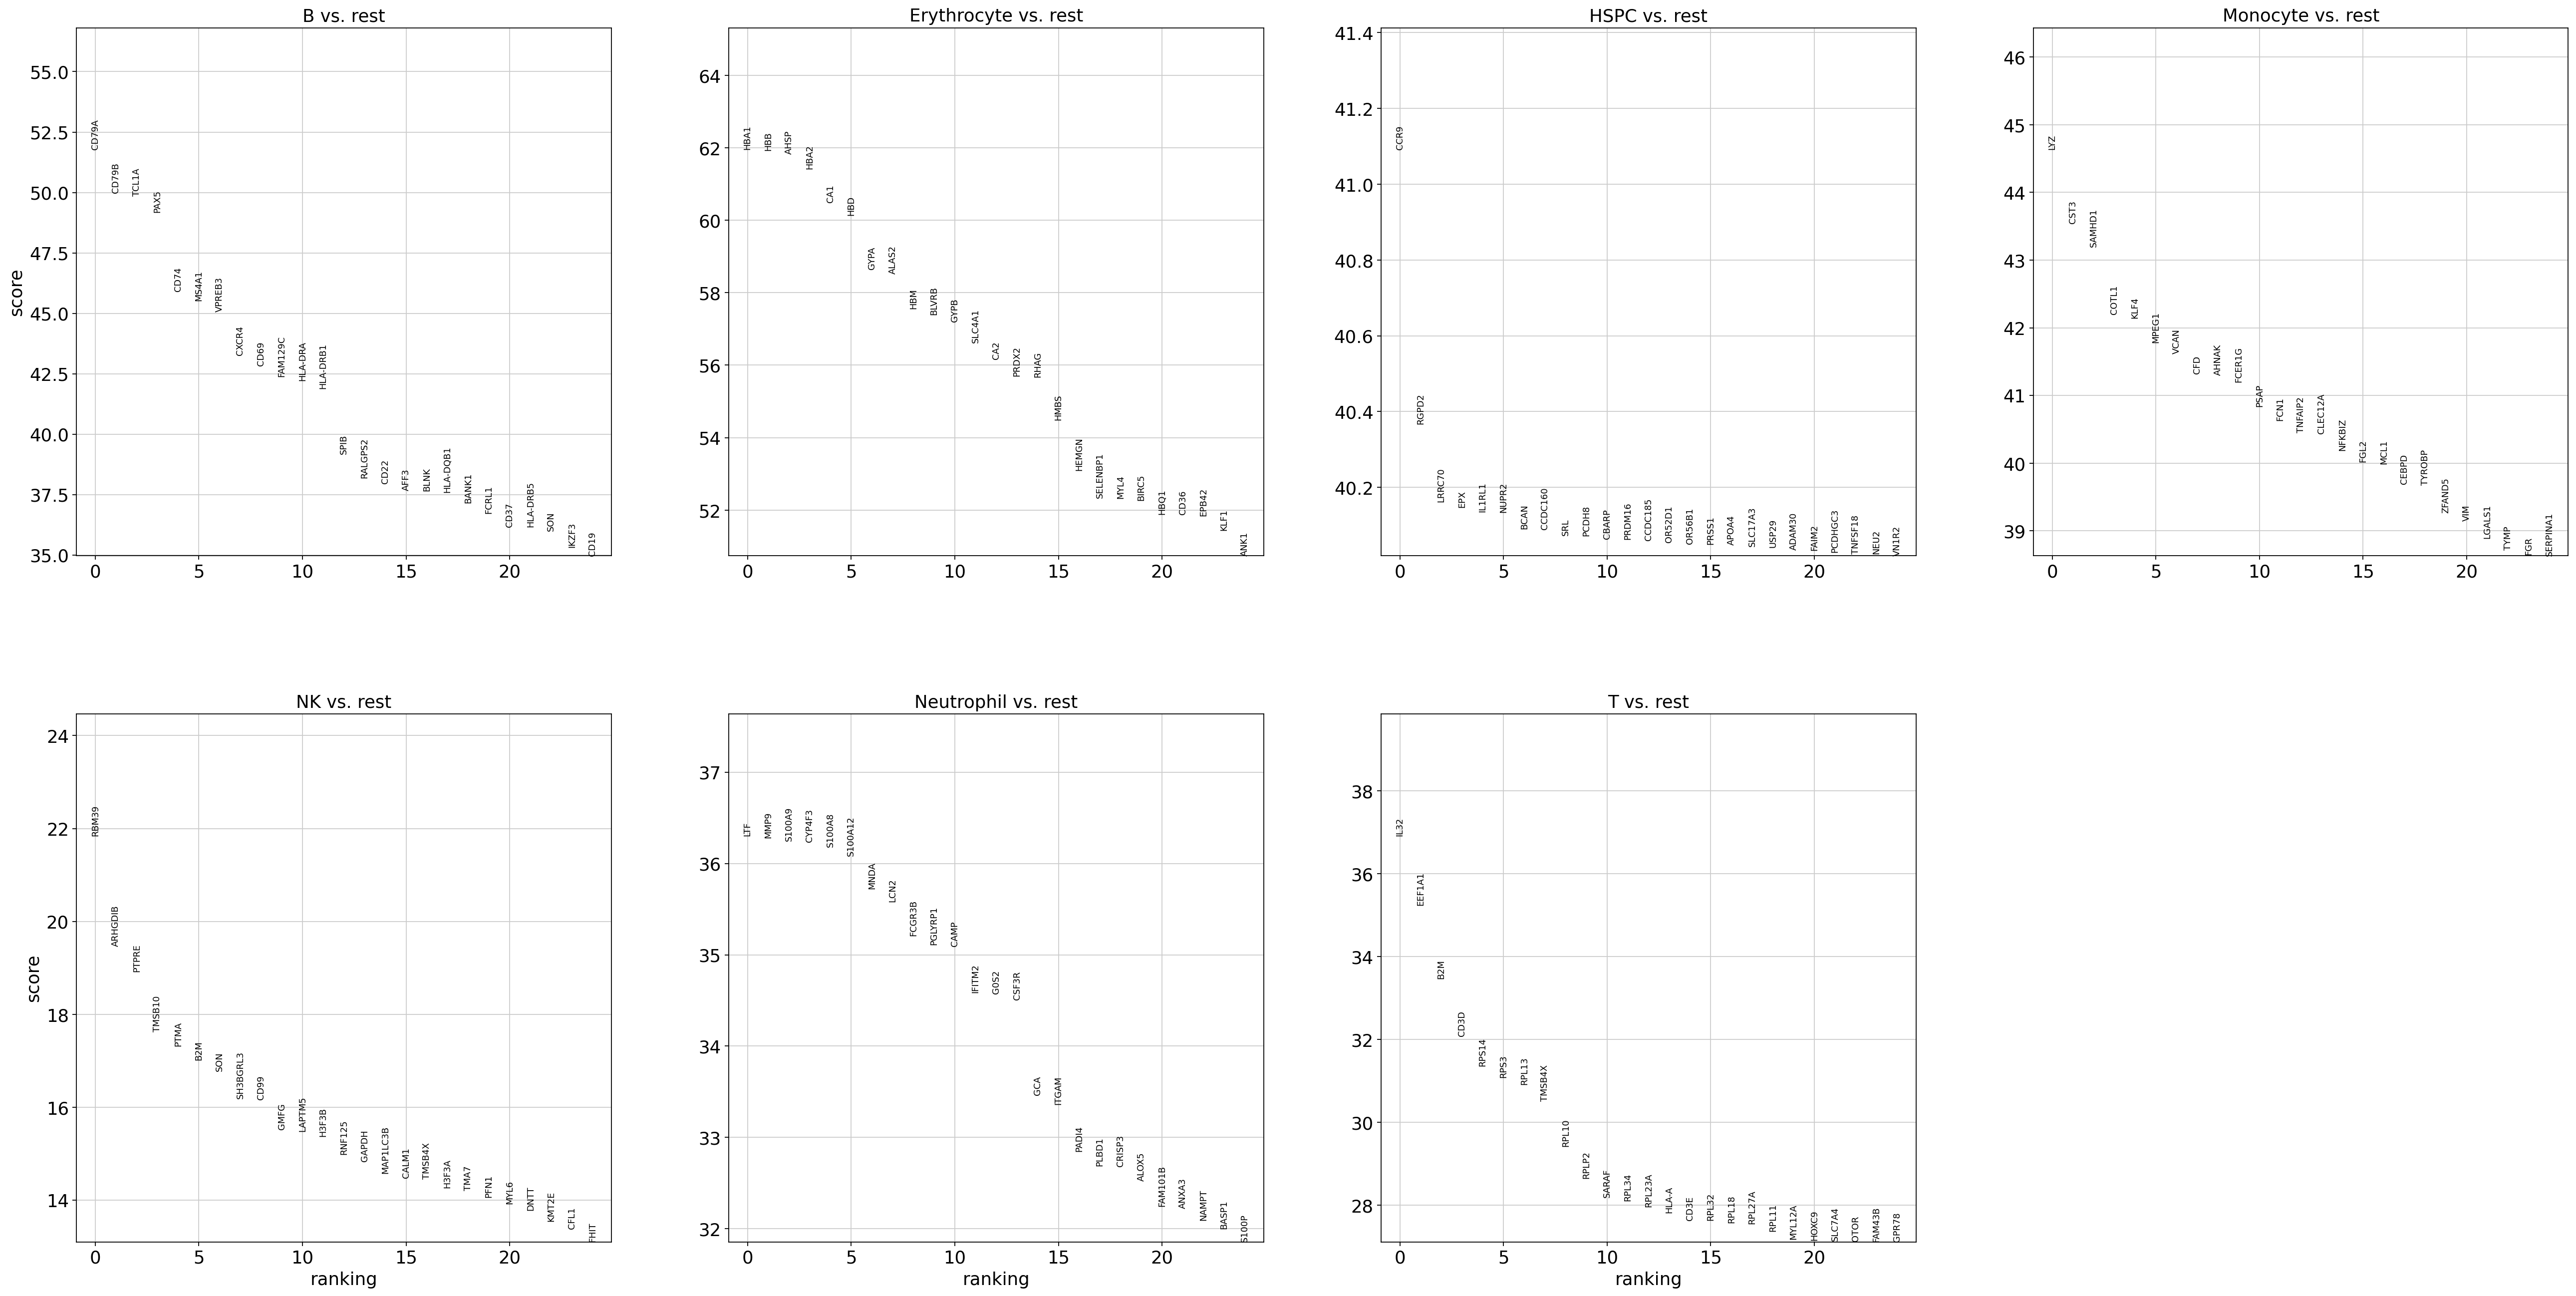

In [ ]:
sc.set_figure_params(figsize=(10,10), fontsize=16)
sc.tl.rank_genes_groups(umi,use_raw=False,groupby='cluster_cell', method='wilcoxon')
sc.pl.rank_genes_groups(umi,n_genes=25,sharey=False)

As we expected from PCA, in the group Monocytes vs rest gene serpina1 is an important differential expressed gene

# The AutoEncoder 

We will create an Auto Encoder (AE) which could have the potential to reduce dimensionality as we did (or maybe better). We use as our input layer all the 18942 genes expressions, since we want the  AE net to discover the pattern that separates celltypes later.

We we build a simple architecture and refine it later, but to begin we can create an architecture of 18942 -> 9k -> 5k -> 2k -> 500 -> 100 -> 500 -> 2k -> 5k -> 9k -> 18942 

In [ ]:
# already standardized
umi = sc.read("/content/drive/MyDrive/AutoEncoder_HSC/GSE149938_umi_matrix_deduplicated_v2.h5ad",cache=True)

We z-scale the log normalized data (0 mean and 1 std) because this will help with vanishing or exploding gradients. Although we normalized each gene, we don't lose information about gene dispersion. Below, the highly variables genes still have the highest std in comparison to other genes.

In [ ]:
# sc.pp.scale(umi)

In [ ]:
# in case you want no log transformed counts
umi.X = umi.raw.X
sc.pp.normalize_total(umi)

In [ ]:
umi.var

n_cells  n_cells_by_counts  mean_counts  log1p_mean_counts  \
FAM231C           4                  4     0.000523           0.000523   
PIK3R3          254                254     0.206725           0.187910   
ATRIP            31                 31     0.025383           0.025066   
CFAP99            8                  8     0.016486           0.016351   
MATR3          1384               1384     1.666754           0.980862   
...             ...                ...          ...                ...   
AC004556.1     1109               1109     0.575036           0.454278   
AC233755.2        5                  5     0.000654           0.000654   
AC233755.1       51                 51     0.032317           0.031806   
AC240274.1      335                335     0.129138           0.121454   
AC213203.1        3                  3     0.000393           0.000392   

            pct_dropout_by_counts  total_counts  log1p_total_counts  \
FAM231C                 99.947665           4.0            1.609438   
PIK3R3                  96.676698        1580.0            7.365813   
ATRIP                   99.594400         194.0            5.273000   
CFAP99                  99.895329         126.0            4.844187   
MATR3                   81.891927       12739.0            9.452502   
...                           ...           ...                 ...   
AC004556.1              85.489991        4395.0            8.388451   
AC233755.2              99.934581           5.0            1.791759   
AC233755.1              99.332723         247.0            5.513429   
AC240274.1              95.616904         987.0            6.895683   
AC213203.1              99.960748           3.0            1.386294   

            highly_variable     means  dispersions  dispersions_norm  \
FAM231C               False  0.000291     0.055990         -2.475869   
PIK3R3                False  0.085172     2.672846          0.390274   
ATRIP                 False  0.014469     1.949512         -0.401966   
CFAP99                False  0.005031     2.758952          0.484583   
MATR3                  True  0.688464     2.962435          0.617055   
...                     ...       ...          ...               ...   
AC004556.1            False  0.200758     1.657780         -0.721489   
AC233755.2            False  0.001422     2.151334         -0.180917   
AC233755.1            False  0.011180     1.363051         -1.044294   
AC240274.1            False  0.062925     1.424210         -0.977310   
AC213203.1            False  0.000093    -1.366668         -4.034052   

                mean       std  
FAM231C     0.000291  0.017543  
PIK3R3      0.088905  1.134654  
ATRIP       0.014575  0.319986  
CFAP99      0.005043  0.282133  
MATR3       0.990655  4.377698  
...              ...       ...  
AC004556.1  0.222329  1.080141  
AC233755.2  0.001423  0.110614  
AC233755.1  0.011243  0.209617  
AC240274.1  0.064947  0.519449  
AC213203.1  0.000093  0.004871  

[18492 rows x 13 columns]

## The Model 

In [6]:
# creating a class for the model 
def create_AE(lr):

  class aenet(nn.Module):
    
    def __init__(self):
      super().__init__()  # get methods from nn.Module 

      # first hidden layer 
      self.inp = nn.Linear(18492, 9000)   # weight between the input and hidden layer
      
      # encoder layer
      self.enc1 = nn.Linear(9000,5000)
      self.bnorm1 = nn.BatchNorm1d(9000)  # batch normalization in each hidden layer 
      self.enc2 = nn.Linear(5000,2000)
      self.bnorm2 = nn.BatchNorm1d(5000)
      self.enc3 = nn.Linear(2000,500)
      self.bnorm3 = nn.BatchNorm1d(2000)
      self.enc4 = nn.Linear(500,100) # bottleneck layer 
      self.bnorm4 = nn.BatchNorm1d(500)
      
      # latent layer 
      self.lat1 = nn.Linear(100,500)
      self.bnorm5 = nn.BatchNorm1d(100)
      self.lat2 = nn.Linear(500,2000)
      self.bnorm6 = nn.BatchNorm1d(500)
      self.lat3 = nn.Linear(2000,5000)
      self.bnorm7 = nn.BatchNorm1d(2000)
      self.lat4 = nn.Linear(5000,9000)
      self.bnorm8 = nn.BatchNorm1d(5000)
      
      # decoder layer 
      self.dec = nn.Linear(9000,18492)

    # forward pass
    def forward(self,x):
      x = F.relu(self.inp(x))   # input layer does not require batch norm
      x = self.bnorm1(x)
      x = F.relu(self.enc1(x))
      x = self.bnorm2(x)
      x = F.relu(self.enc2(x))
      x = self.bnorm3(x)
      x = F.relu(self.enc3(x))

      x_ = self.bnorm4(x)
      x = F.relu(self.enc4(x_)) 
      y_lat = self.enc4(x_) # getting the latent features output 
      
      x = self.bnorm5(x)
      x = F.relu(self.lat1(x))
      x = self.bnorm6(x)
      x = F.relu(self.lat2(x))
      x = self.bnorm7(x)
      x = F.relu(self.lat3(x))
      x = self.bnorm8(x)
      x = F.relu(self.lat4(x))
      y = self.dec(x)   

      return y, y_lat

  # create model instance
  net = aenet()

  # loss function 
  lossfun = nn.MSELoss()

  # optimizer 
  optimizer = torch.optim.RMSprop(net.parameters(), lr=lr)
  #optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9)
  stepsize = 0
  #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',patience=10,factor=0.95,threshold_mode='abs',min_lr=0.0000005,threshold=0.001)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 2000, gamma=0.1)
  #scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,gamma=0.90)

  return net, lossfun, optimizer, scheduler

## The training 

In [7]:
def plot_losses(losses, lr, optimizer, batches):
  plt.plot(losses, '-o')
  plt.xlabel('epochs')
  plt.ylabel('loss')
  plt.title(f'Lr: {lr} Batches: {batches} with Optimizer: {(type (optimizer).__name__)}')
  plt.show()
  return 

def ae_training(X,epochs,batches,lr, checkpoint, save=True, loadpath='./', savepath=''):

  # number of epochs 
  n_epochs = epochs

  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
  print("Using ", device)
  
  # create a new model if it does not exists
  if not checkpoint:
    net, lossfun, optimizer,scheduler = create_AE(lr)
    net.to(device) 
  else:
    print('Using saved model from last checkpoint')
    net_dict = torch.load(loadpath,map_location=device)
    net, lossfun, optimizer,scheduler = create_AE(lr)
    # send it to GPU if available 
    net.to(device) 
    net.load_state_dict(net_dict['ae_state_dict'])
    optimizer.load_state_dict(net_dict['optimizer_state_dict'])
    optimizer.param_groups[0]['lr'] = lr
    print(f"Setting learning rate to {lr}")




  # initiliaze losses 
  losses = torch.zeros(n_epochs)

  # loop over epochs 
  for epoch in range(n_epochs):
    print(f"In epoch {epoch+1} out of {n_epochs}")

    # shuffle the dataset 
    shuffle_idx = torch.randperm(X.shape[0],device=device)
    # make sure is a int number of mini-batches
    n = shuffle_idx.shape[0]//batches

    # loop over mini-batches
    for i in range(0,shuffle_idx.shape[0],batches):
      if i == shuffle_idx.shape[0]-1:  # batches with different sizes leads to inconsistencies! 
        if shuffle_idx[i:].shape[0] != batches:
          break
      else:
        # create the mini-batch 
        idx_mini = shuffle_idx[i:i+batches]
        X_mini = X[idx_mini] 
      
      # forward pass and loss
      y_hat,y_lat = net(X_mini)
      loss = lossfun(y_hat,X_mini)   # we directly compare the input and output! 

      # backprop
      optimizer.zero_grad()
      loss.backward()
      # clipping gradient weights
      torch.nn.utils.clip_grad_norm_(net.parameters(), 1.)
      optimizer.step()

      

      # accumulates mini-batches losses
      losses[epoch] += loss.item()
    
    # epoch loss = avg loss of mini-batches
    losses[epoch] /= n  
    print(f"Avg epoch loss: {losses[epoch]}\n")
    scheduler.step(losses[epoch])
  
  plot_losses(losses, lr, optimizer, batches)
  if save:
    torch.save({
              'ae_state_dict': net.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
                }, f"{savepath}/ae_epoch{epoch}_lr{lr}_btch{batches}_optm{(type (optimizer).__name__)}.pt")
  print(f"Model saved as {savepath}/ae_epoch{epoch}_lr{lr}_btch{batches}_optm{(type (optimizer).__name__)}.pt")
  
  return losses, net, optimizer,scheduler

In [ ]:
# to split data in case of performance issues
import sklearn

strat_shuffle = sklearn.model_selection.StratifiedShuffleSplit(n_splits=20, test_size=0.2)

for train_index in strat_shuffle.split(umi.X, umi.obs['celltype']):
  train_index = train_index

len(train_index[0]), len(train_index[1])

umi[train_index[1],:].obs.value_counts('celltype')

(5992, 1498)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
X = torch.tensor(umi.X, device=device)
#del umi
X[:10], X.shape

(tensor([[-0.0188, -0.1184, -0.0546,  ..., -0.0500, -0.1673, -0.0103],
         [-0.0174, -0.1437, -0.0556,  ..., -0.0697, -0.1645, -0.0211],
         [-0.0152, -0.1857, -0.0573,  ...,  2.5758, -0.1598, -0.0391],
         ...,
         [-0.0146,  6.7100, -0.0577,  ..., -0.1113, -0.1585, -0.0440],
         [-0.0163, -0.1639, -0.0564,  ...,  3.4140, -0.1622, -0.0298],
         [-0.0174, -0.1449, -0.0557,  ..., -0.0707, -0.1644, -0.0216]]),
 torch.Size([7490, 18492]))

Using  cuda:0
In epoch 1 out of 250
Avg epoch loss: 1.035774827003479

In epoch 2 out of 250
Avg epoch loss: 0.9427833557128906

In epoch 3 out of 250
Avg epoch loss: 0.9395259618759155

In epoch 4 out of 250
Avg epoch loss: 0.933255672454834

In epoch 5 out of 250
Avg epoch loss: 0.9281314611434937

In epoch 6 out of 250
Avg epoch loss: 0.9252457618713379

In epoch 7 out of 250
Avg epoch loss: 0.9216558933258057

In epoch 8 out of 250
Avg epoch loss: 0.9150668978691101

In epoch 9 out of 250
Avg epoch loss: 0.9136109948158264

In epoch 10 out of 250
Avg epoch loss: 0.9059080481529236

In epoch 11 out of 250
Avg epoch loss: 0.8995317816734314

In epoch 12 out of 250
Avg epoch loss: 0.8945400714874268

In epoch 13 out of 250
Avg epoch loss: 0.8850008845329285

In epoch 14 out of 250
Avg epoch loss: 0.8791885375976562

In epoch 15 out of 250
Avg epoch loss: 0.8745648860931396

In epoch 16 out of 250
Avg epoch loss: 0.8616580963134766

In epoch 17 out of 250
Avg epoch loss: 0.850878953933

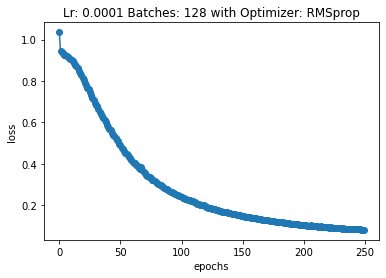

Model saved as /content/drive/MyDrive/AutoEncoder_HSC/Teste/ae_epoch249_lr0.0001_btch128_optmRMSprop.pt


In [ ]:
losses, net, optimizer = ae_training(X,250,128,0.0001,checkpoint=False,save=True,savepath="/content/drive/MyDrive/AutoEncoder_HSC/Teste")

## Loading trained model 

Using  cuda:0
Using saved model from last checkpoint
Setting learning rate to 5e-05
In epoch 1 out of 100
Avg epoch loss: 0.06646952033042908

In epoch 2 out of 100
Avg epoch loss: 0.060223277658224106

In epoch 3 out of 100
Avg epoch loss: 0.05863591656088829

In epoch 4 out of 100
Avg epoch loss: 0.05823821201920509

In epoch 5 out of 100
Avg epoch loss: 0.059083934873342514

In epoch 6 out of 100
Avg epoch loss: 0.05781099572777748

In epoch 7 out of 100
Avg epoch loss: 0.05795636400580406

In epoch 8 out of 100
Avg epoch loss: 0.05773231014609337

In epoch 9 out of 100
Avg epoch loss: 0.0574100986123085

In epoch 10 out of 100
Avg epoch loss: 0.056837111711502075

In epoch 11 out of 100
Avg epoch loss: 0.05658642202615738

In epoch 12 out of 100
Avg epoch loss: 0.05634743720293045

In epoch 13 out of 100
Avg epoch loss: 0.056019872426986694

In epoch 14 out of 100
Avg epoch loss: 0.056244198232889175

In epoch 15 out of 100
Avg epoch loss: 0.05621827021241188

In epoch 16 out of 10

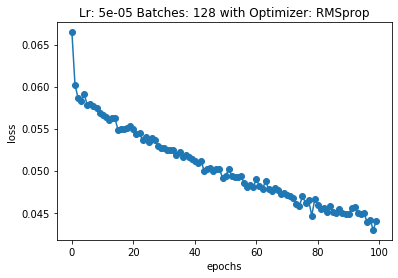

Model saved as /content/drive/MyDrive/AutoEncoder_HSC/Teste/ae_epoch99_lr5e-05_btch128_optmRMSprop.pt


In [ ]:
# retraining from checkpoint
losses, net, optimizer,scheduler = ae_training(X,100,128,0.00005,True,
                                     save=True,
                                     loadpath="/content/drive/MyDrive/AutoEncoder_HSC/Teste/ae_epoch249_lr0.0001_btch128_optmRMSprop.pt",
                                     savepath="/content/drive/MyDrive/AutoEncoder_HSC/Teste")

Using  cuda:0
Using saved model from last checkpoint
Setting learning rate to 8.5e-06
In epoch 1 out of 200
Avg epoch loss: 0.04054514691233635

In epoch 2 out of 200
Avg epoch loss: 0.03744947165250778

In epoch 3 out of 200
Avg epoch loss: 0.03669264540076256

In epoch 4 out of 200
Avg epoch loss: 0.03610171005129814

In epoch 5 out of 200
Avg epoch loss: 0.03534548357129097

In epoch 6 out of 200
Avg epoch loss: 0.034930821508169174

In epoch 7 out of 200
Avg epoch loss: 0.034750647842884064

In epoch 8 out of 200
Avg epoch loss: 0.03459955379366875

In epoch 9 out of 200
Avg epoch loss: 0.03394101932644844

In epoch 10 out of 200
Avg epoch loss: 0.034320659935474396

In epoch 11 out of 200
Avg epoch loss: 0.03358382359147072

In epoch 12 out of 200
Avg epoch loss: 0.033891260623931885

In epoch 13 out of 200
Avg epoch loss: 0.03429761156439781

In epoch 14 out of 200
Avg epoch loss: 0.03426286205649376

In epoch 15 out of 200
Avg epoch loss: 0.0339919812977314

In epoch 16 out of 2

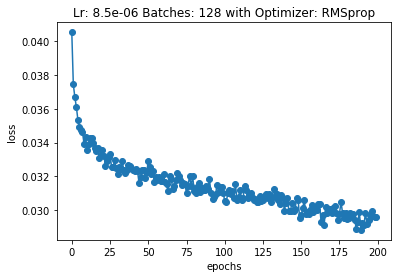

Model saved as /content/drive/MyDrive/AutoEncoder_HSC/Teste/ae_epoch199_lr8.5e-06_btch128_optmRMSprop.pt


In [ ]:
# retraining from checkpoint
losses, net, optimizer,scheduler = ae_training(X,200,128,0.0000085,True,
                                     save=True,
                                     loadpath="/content/drive/MyDrive/AutoEncoder_HSC/Teste/ae_epoch99_lr5e-05_btch128_optmRMSprop.pt",
                                     savepath="/content/drive/MyDrive/AutoEncoder_HSC/Teste")


## Plotting the latent space of the AE model to UMAP

In [ ]:
loadpath='/content/drive/MyDrive/AutoEncoder_HSC/Teste/ae_epoch199_lr8.5e-06_btch128_optmRMSprop.pt'
net_dict = torch.load(loadpath,map_location=device)
net, lossfun, optimizer,scheduler = create_AE(0.0005)
# send it to GPU if available 
net.to(device) 
net.load_state_dict(net_dict['ae_state_dict'])
optimizer.load_state_dict(net_dict['optimizer_state_dict'])

In [ ]:
net.eval()   # toggle off batch normalization
y_hat, y_lat = net(X)

In [ ]:
y_lat

tensor([[0.4813, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [2.8209, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 3.2621, 0.0000,  ..., 0.0000, 0.0000, 1.7738],
        ...,
        [2.2013, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.5728, 0.0000, 1.7930]],
       grad_fn=<ReluBackward0>)

In [ ]:
y_lat.shape

torch.Size([7490, 100])

In [ ]:
lat = y_lat.cpu().detach().numpy()

In [ ]:
a = sc.AnnData(lat)

In [ ]:
a.X

array([[0.48125845, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [2.8209214 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 3.2621384 , 0.        , ..., 0.        , 0.        ,
        1.7738049 ],
       ...,
       [2.201267  , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.5727662 , 0.        ,
        1.7929702 ]], dtype=float32)

In [ ]:
a.obs['cluster_cell'] = umi.obs['cluster_cell'].values
a.obs['celltype'] = umi.obs['celltype'].values

In [ ]:
sc.pp.scale(a)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:17)


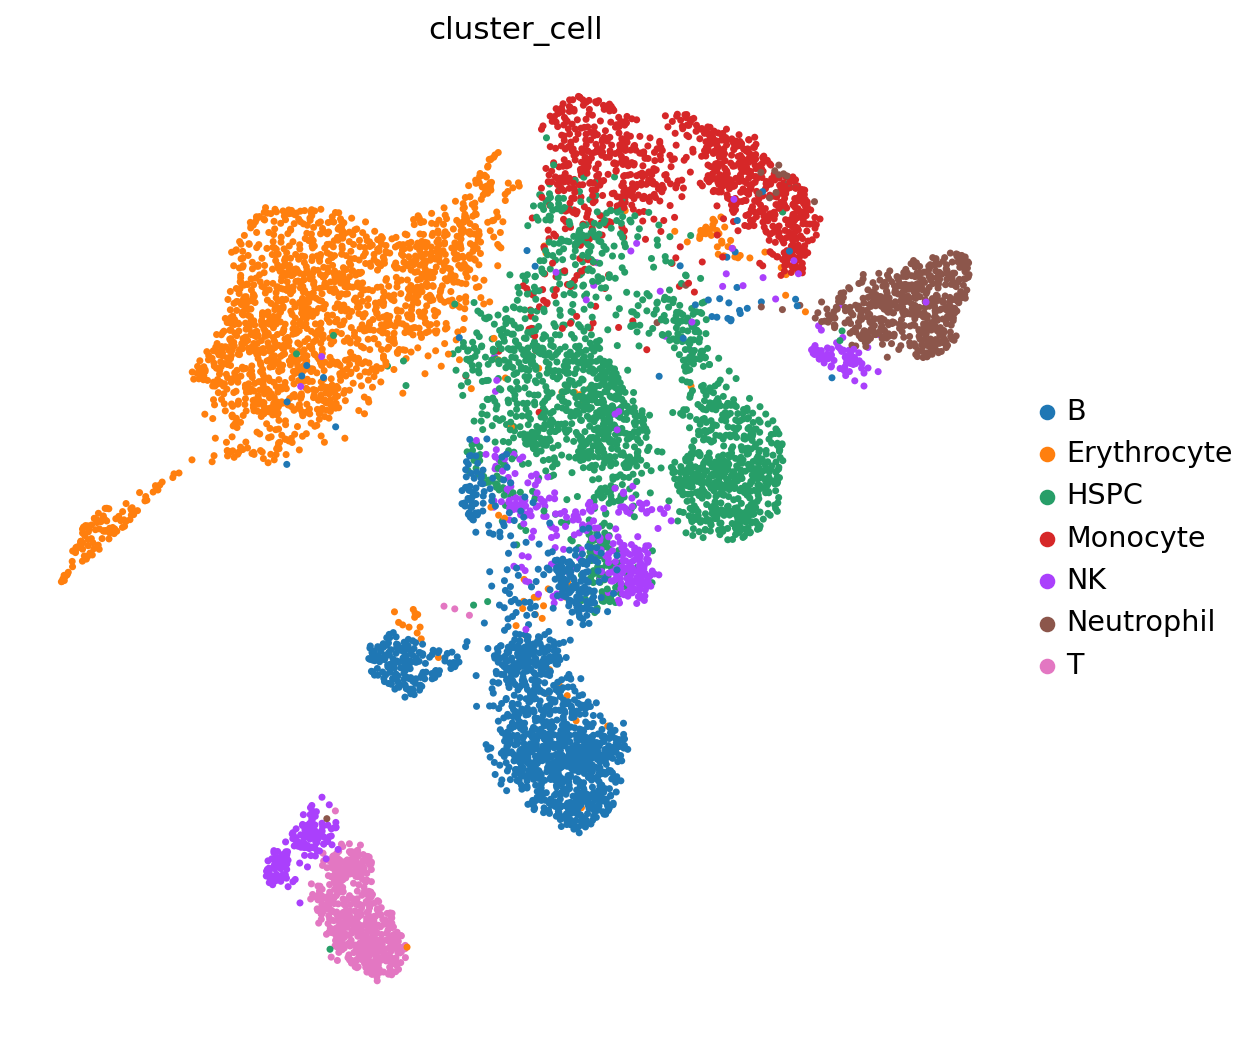

In [ ]:
#sc.tl.pca(a, n_comps=50)
sc.pp.neighbors(a, n_neighbors=10, use_rep='X', metric='euclidean')
sc.tl.umap(a,min_dist=0.7,spread=2)
sc.set_figure_params(figsize=(8,8))
sc.pl.umap(a,color='cluster_cell', show=True, frameon=False,size=40)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:05)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:18)


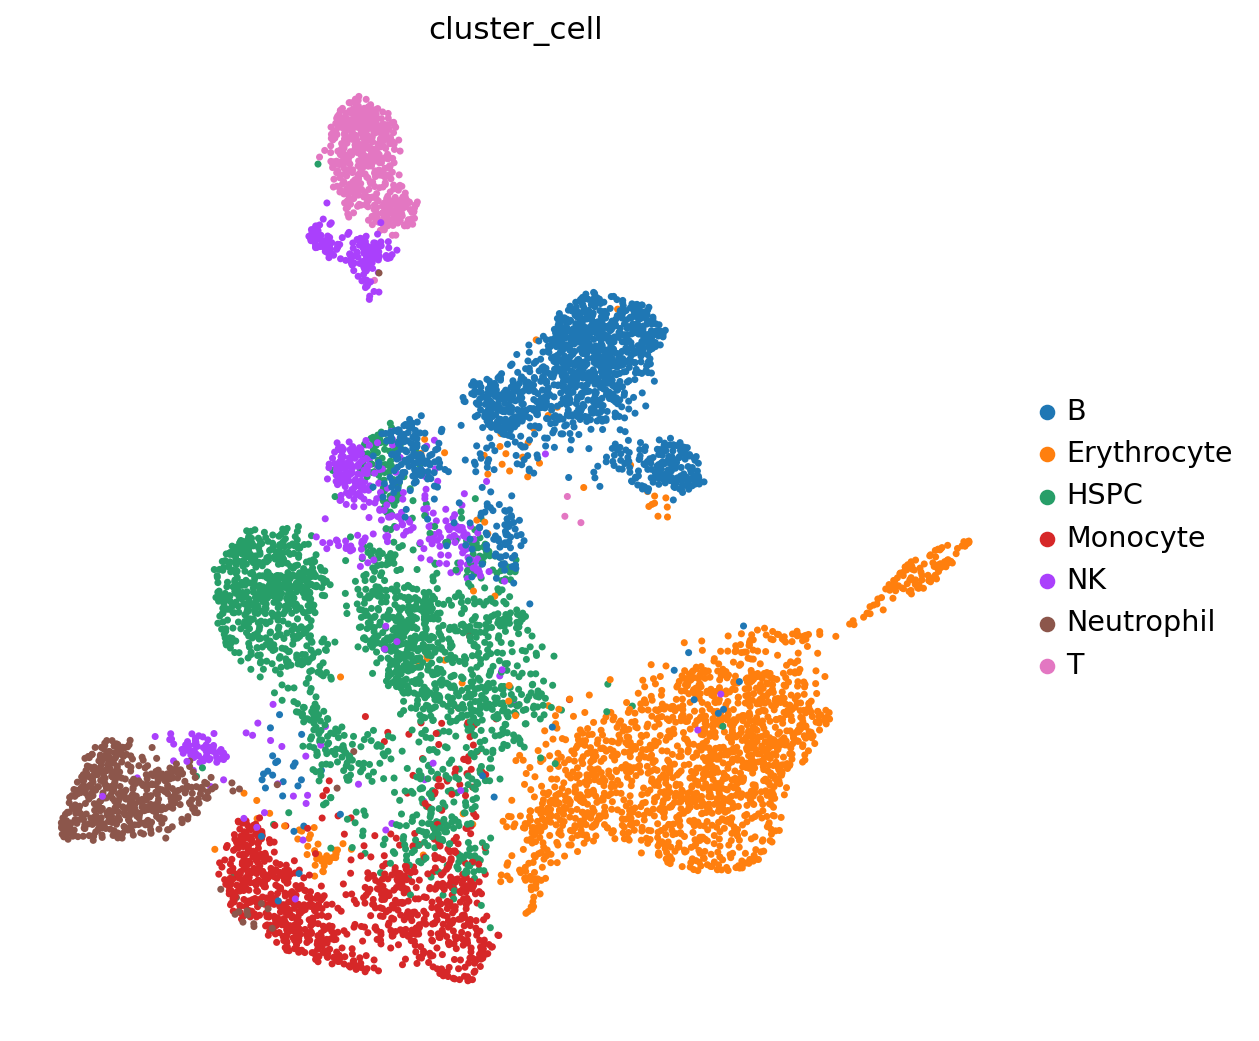

In [ ]:
#sc.tl.pca(a, n_comps=50)
# no batch norm -- eval mode
sc.pp.neighbors(a, n_neighbors=10, use_rep='X', metric='euclidean')
sc.tl.umap(a,min_dist=0.7,spread=2)
sc.set_figure_params(figsize=(8,8))
sc.pl.umap(a,color='cluster_cell', show=True, frameon=False,size=40)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:17)


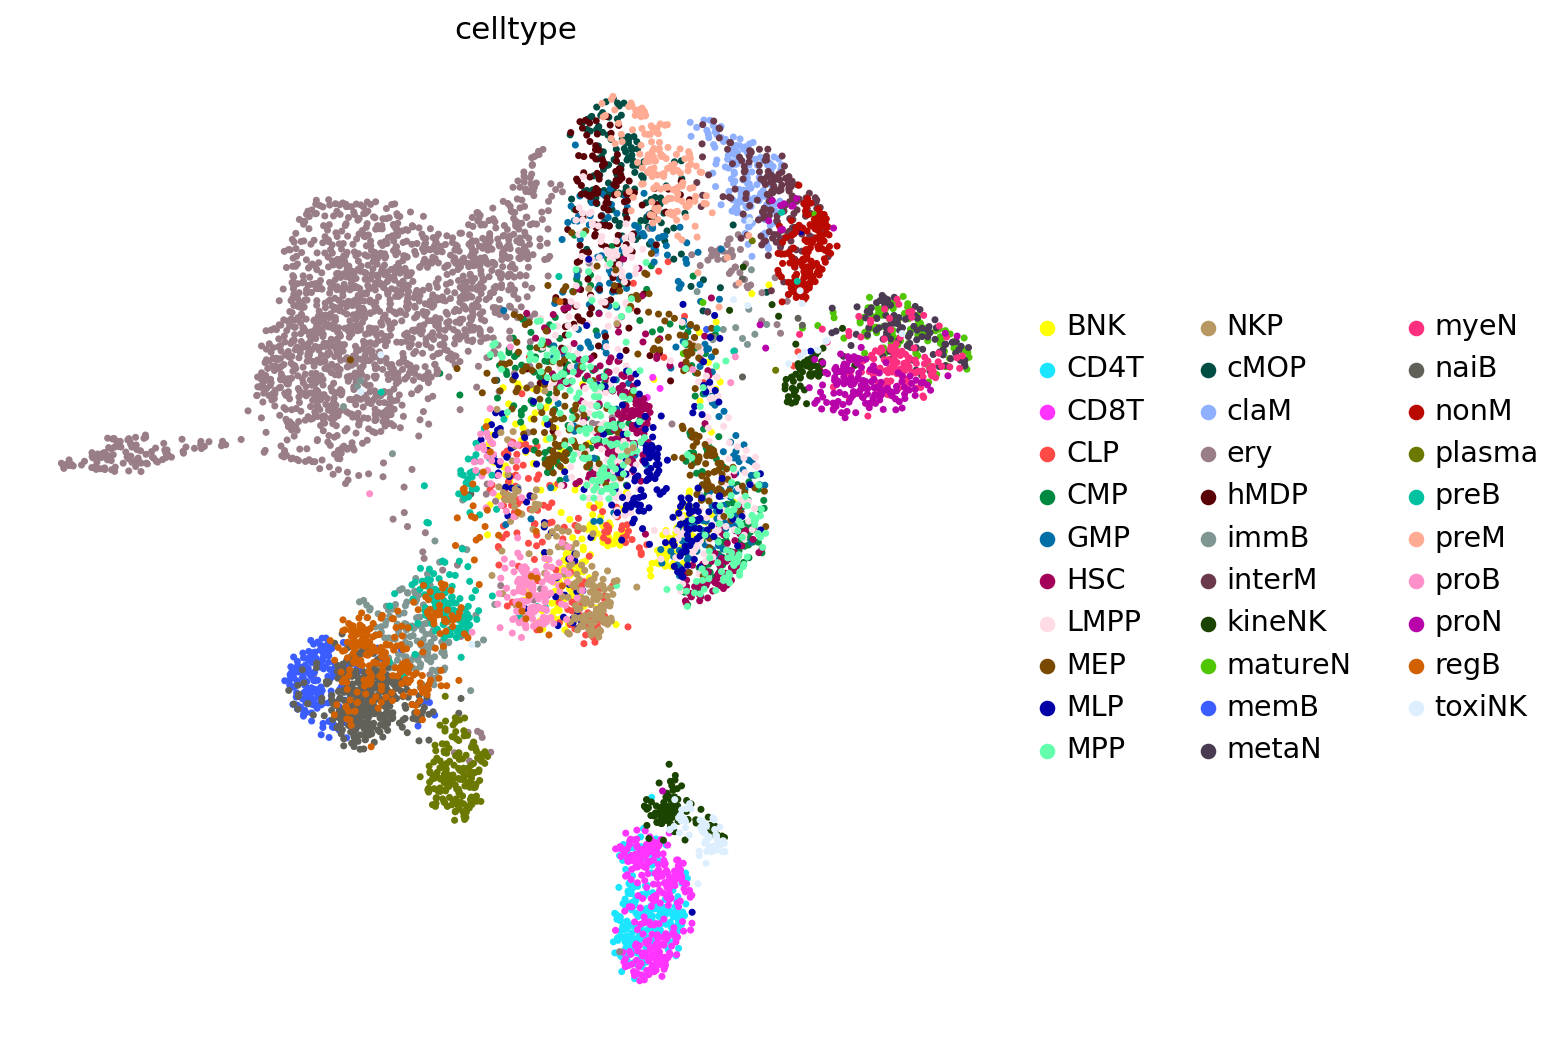

In [ ]:
#sc.tl.pca(a, n_comps=50)
sc.pp.neighbors(a, n_neighbors=10, use_rep='X', metric='euclidean')
sc.tl.umap(a,min_dist=0.5)
sc.set_figure_params(figsize=(8,8))
sc.pl.umap(a,color='celltype', show=True, frameon=False,size=40)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:18)


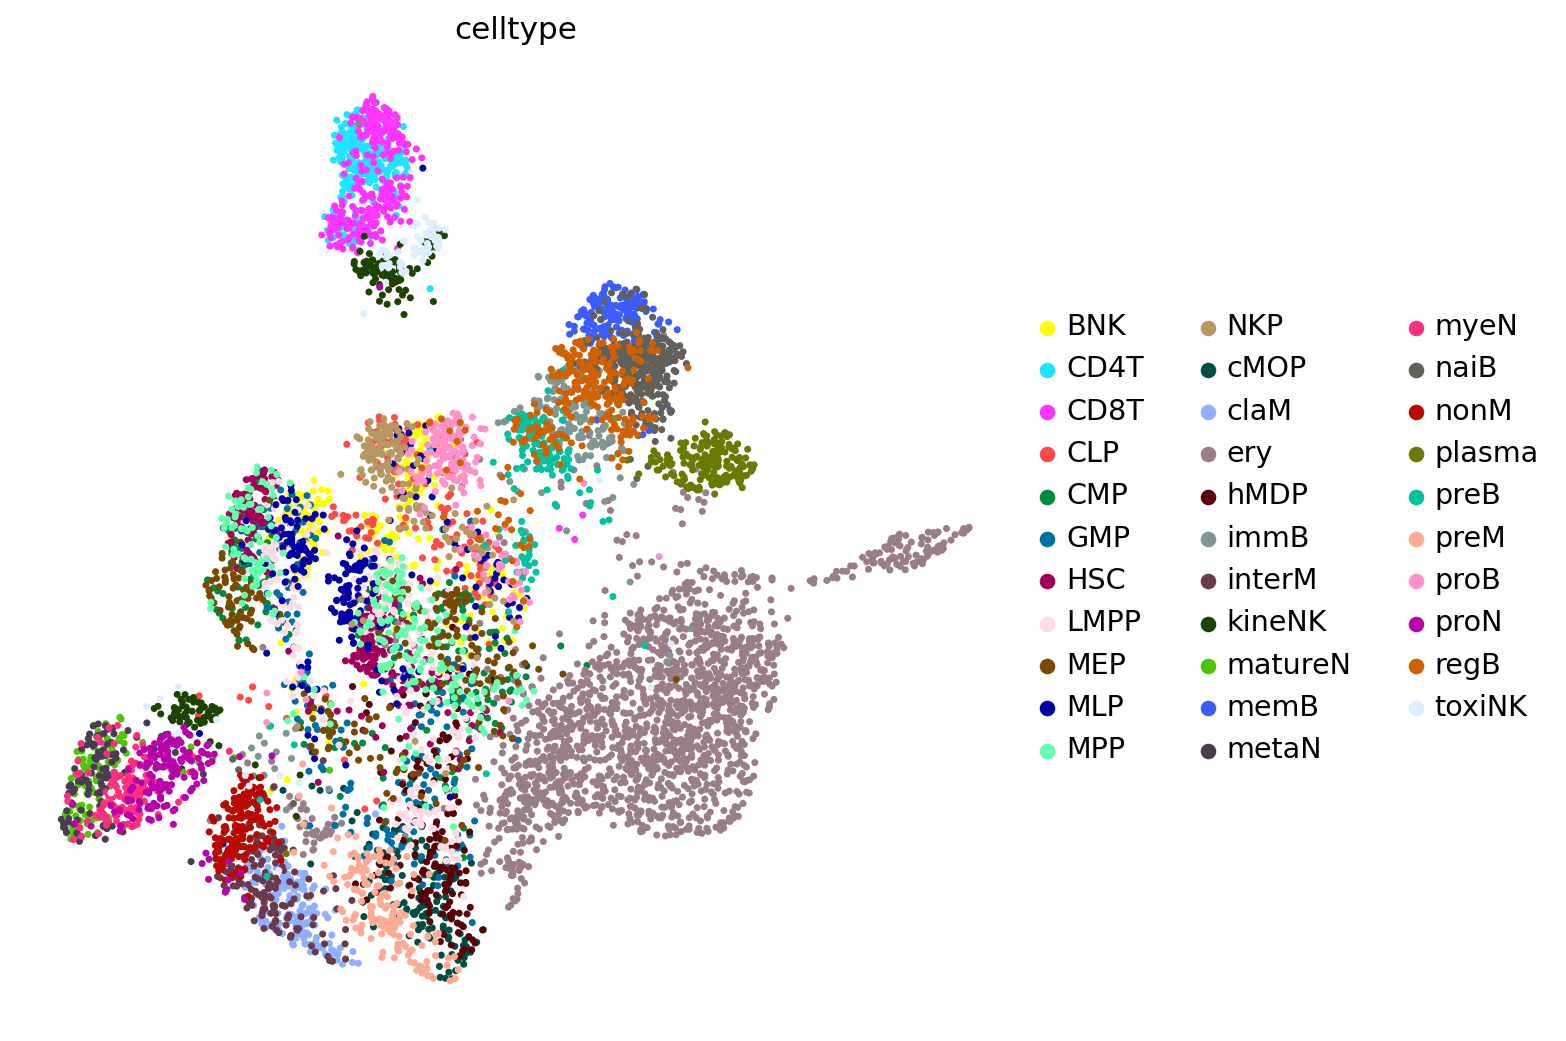

In [ ]:
#sc.tl.pca(a, n_comps=50)
# no batch norm -- eval mode
sc.pp.neighbors(a, n_neighbors=10, use_rep='X', metric='euclidean')
sc.tl.umap(a,min_dist=0.5)
sc.set_figure_params(figsize=(8,8))
sc.pl.umap(a,color='celltype', show=True, frameon=False,size=40)

In [ ]:
sc.pp.scale(umi)
umi.X


array([[-0.01879716, -0.11841827, -0.05459259, ..., -0.04995743,
        -0.16731824, -0.01025622],
       [-0.0174378 , -0.14368127, -0.05560071, ..., -0.06967576,
        -0.16449806, -0.0210922 ],
       [-0.0151744 , -0.18574563, -0.05727929, ...,  2.5757706 ,
        -0.15980232, -0.03913473],
       ...,
       [-0.01940806, -0.10706504, -0.05413955, ..., -0.041096  ,
        -0.16858563, -0.00538652],
       [-0.01851503, -0.12366149, -0.05480183, ..., -0.05404988,
        -0.16673292, -0.01250518],
       [-0.01809055, -0.13155024, -0.05511663, ..., -0.06020722,
        -0.16585228, -0.01588887]], dtype=float32)

In [ ]:
umi

AnnData object with n_obs × n_vars = 7490 × 18492
    obs: 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'celltype', 'lane', 'cluster_cell'
    var: 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'celltype_colors', 'cluster_cell_colors', 'hvg', 'lane_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'normalized'
    obsp: 'connectivities', 'distances'

### Plotting UMAP from PCA

computing PCA
    on highly variable genes
    with n_comps=100
    finished (0:00:07)
computing neighbors
    using 'X_pca' with n_pcs = 100
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:19)


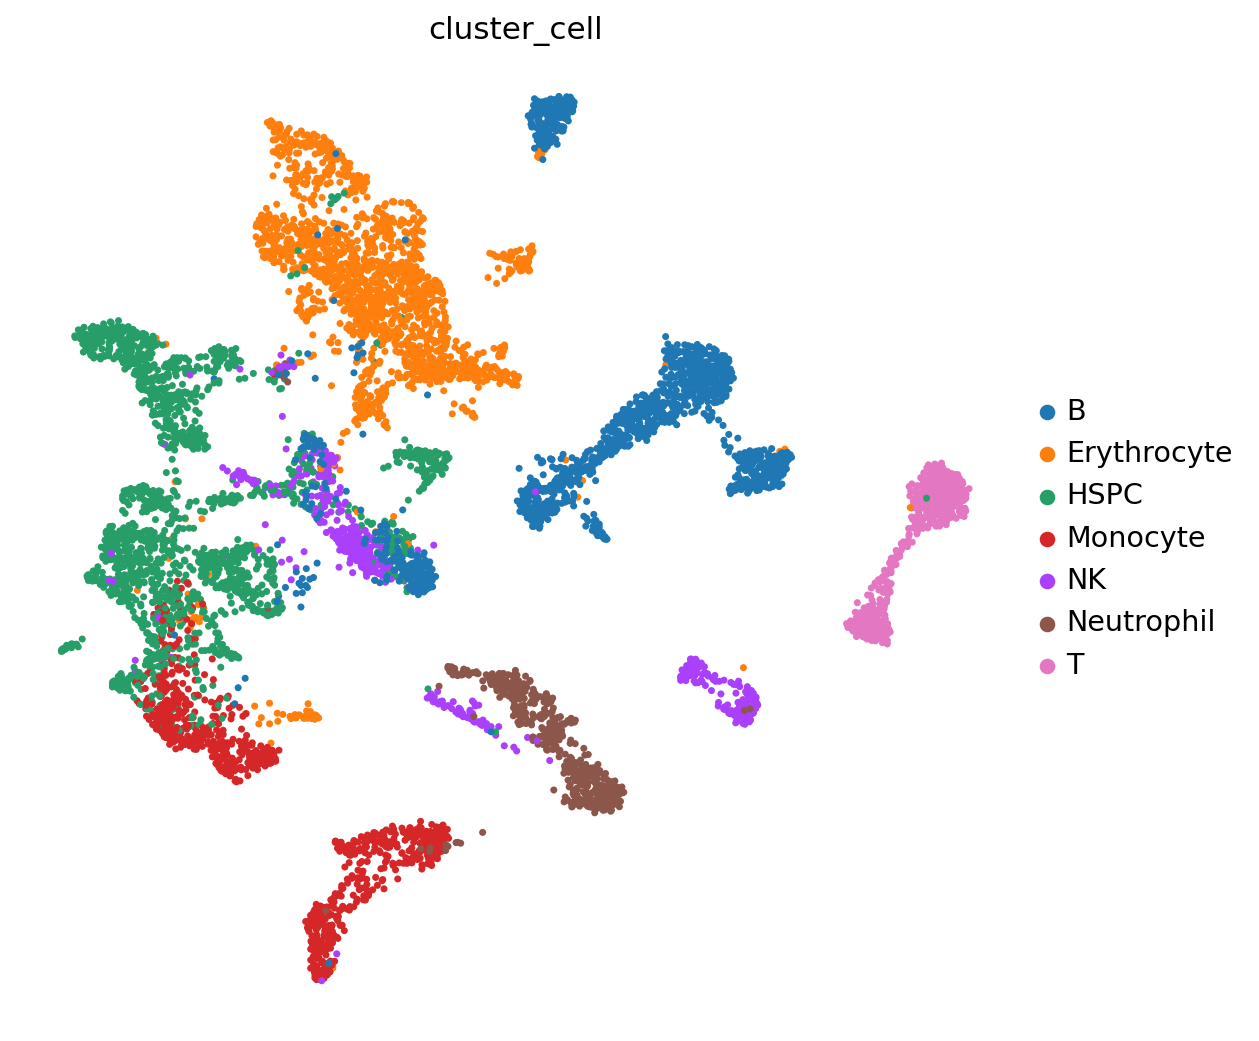

In [ ]:
sc.tl.pca(umi, n_comps=100)
sc.pp.neighbors(umi, n_neighbors=10, metric='euclidean',n_pcs=100)
sc.tl.umap(umi,min_dist=0.7,spread=2)
sc.set_figure_params(figsize=(8,8))
sc.pl.umap(umi,color='cluster_cell', show=True, frameon=False,size=40)

computing PCA
    on highly variable genes
    with n_comps=100
    finished (0:00:04)
computing neighbors
    using 'X_pca' with n_pcs = 100
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:19)


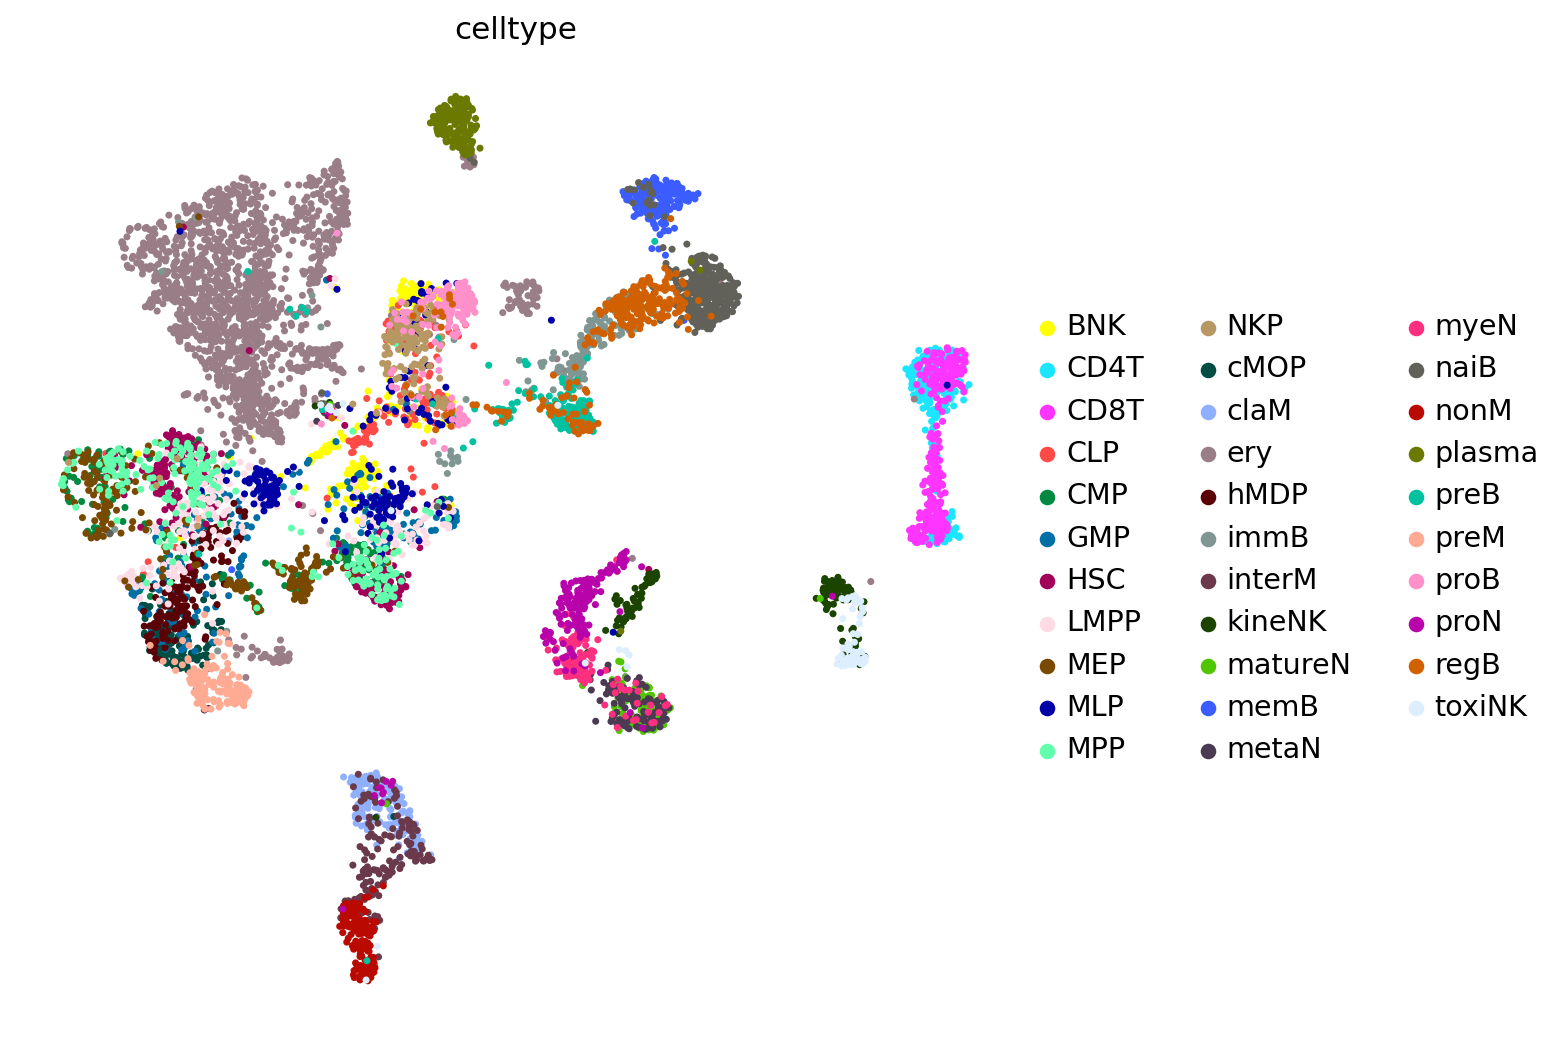

In [ ]:
sc.tl.pca(umi, n_comps=100)
sc.pp.neighbors(umi, n_neighbors=10, metric='euclidean',n_pcs=100)
sc.tl.umap(umi,min_dist=0.5)
sc.set_figure_params(figsize=(8,8))
sc.pl.umap(umi,color='celltype', show=True, frameon=False,size=40)

**Notice** that UMAP-PCA has HSPCs not as centered as UMAP-AE. That is an important fact, because HSPCs are the progenitors of all cells and should be correlated in distance to all other clusters. Also, clusters from UMAP-PCA are more spread, like the Monocytes(red)

# Checking output of AE by fitting a line 

The ideia is that each input X and predicted X  can form pairs of data points using $(x_{ij}, \hat{x}_{ij})$ where xi is the ith cell of the dataset and jth gene. 

Then, the $r^2$ score is evaluated.

In [8]:
# already standardized
umi = sc.read("/content/drive/MyDrive/AutoEncoder_HSC/GSE149938_umi_matrix_deduplicated_v2.h5ad",cache=True)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
X = torch.tensor(umi.X, device=device)

In [9]:
loadpath='/content/drive/MyDrive/AutoEncoder_HSC/Teste/ae_epoch499_lr5e-06_btch800_optmRMSprop.pt'
net_dict = torch.load(loadpath, map_location=device)
net, lossfun, optimizer,scheduler = create_AE(0.0005)
# send it to GPU if available 
net.to(device) 
net.load_state_dict(net_dict['ae_state_dict'])
optimizer.load_state_dict(net_dict['optimizer_state_dict'])

In [10]:
net.eval()
with torch.no_grad():
  y_hat, y_lat = net(X)

In [ ]:
y_hat[0,:10], X[0,:10]

(tensor([-0.0144, -0.1076, -0.0740, -0.0105, -0.3946, -0.0376, -0.3786, -0.1849,
         -0.3134, -0.3397], device='cuda:0'),
 tensor([-0.0188, -0.1184, -0.0546, -0.0253, -0.3587, -0.0341, -0.3756, -0.2216,
         -0.3235, -0.3923], device='cuda:0'))

In [ ]:
y_lat.shape

torch.Size([7490, 100])

In [12]:
torch.save(y_lat,'/content/drive/MyDrive/AutoEncoder_HSC/ae_latent_vectors_fromr2_0995_norelu.pt')

In [ ]:
x_hat = y_hat.cpu().numpy()
x_target = X.cpu().numpy()

In [ ]:
from sklearn.metrics import r2_score

In [ ]:
r2_score(x_target, x_hat)

0.9951881643570045

Goal: $r^2$ score >= 0.99 

Using  cuda:0
Using saved model from last checkpoint
Setting learning rate to 5e-06
In epoch 1 out of 500
Avg epoch loss: 0.013421686366200447

In epoch 2 out of 500
Avg epoch loss: 0.01298554241657257

In epoch 3 out of 500
Avg epoch loss: 0.012769452296197414

In epoch 4 out of 500
Avg epoch loss: 0.012603879906237125

In epoch 5 out of 500
Avg epoch loss: 0.012514994479715824

In epoch 6 out of 500
Avg epoch loss: 0.012567896395921707

In epoch 7 out of 500
Avg epoch loss: 0.012555595487356186

In epoch 8 out of 500
Avg epoch loss: 0.012460874393582344

In epoch 9 out of 500
Avg epoch loss: 0.0122148422524333

In epoch 10 out of 500
Avg epoch loss: 0.012056996114552021

In epoch 11 out of 500
Avg epoch loss: 0.012372584082186222

In epoch 12 out of 500
Avg epoch loss: 0.012058598920702934

In epoch 13 out of 500
Avg epoch loss: 0.012074683792889118

In epoch 14 out of 500
Avg epoch loss: 0.012077932246029377

In epoch 15 out of 500
Avg epoch loss: 0.011921614408493042

In epoch 16 o

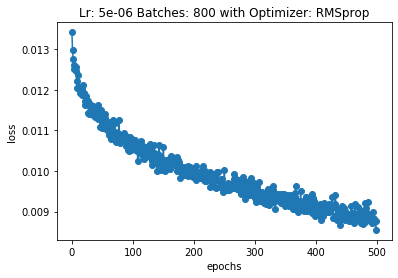

Model saved as /content/drive/MyDrive/AutoEncoder_HSC/Teste/ae_epoch499_lr5e-06_btch800_optmRMSprop.pt


In [ ]:
# retraining from checkpoint
losses, net, optimizer,scheduler = ae_training(X,500,800,5e-6,True,
                                     save=True,
                                     loadpath="/content/drive/MyDrive/AutoEncoder_HSC/Teste/ae_epoch199_lr8.5e-06_btch128_optmRMSprop.pt",
                                     savepath="/content/drive/MyDrive/AutoEncoder_HSC/Teste")